In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import json
import re
from tqdm import tqdm

In [2]:
inDIR = './cnn_test_results_2cm/'
model_prefix = 'deeplabplus_*'

In [3]:
if not os.path.exists('./results_figs/'):
    os.mkdir('./results_figs/')
if not os.path.exists('./results_tables/'):
    os.mkdir('./results_tables/')

In [4]:
idx = 0
for d in tqdm(glob.glob(os.path.join('.', 'cnn_results_' + model_prefix))):
    res_tmp = os.path.basename(d).split('_')[-1]
    for f in glob.glob(os.path.join(d, '*validation.txt')):
        inputs_tmp = re.sub('_' + res_tmp, '', re.sub('_validation.txt', '', re.sub('best_model_', '', os.path.basename(f))))
        if idx == 0:
            with open(f, 'r') as src:
                train_valid = eval(src.read())
                df_train_valid = pd.DataFrame(train_valid, index=[idx])
                df_train_valid['inputs'] = inputs_tmp
        else:
            with open(f, 'r') as src:
                train_valid = eval(src.read())
                df_train_valid_tmp = pd.DataFrame(train_valid, index=[idx])
                df_train_valid_tmp['inputs'] = inputs_tmp
                df_train_valid = pd.concat([df_train_valid, df_train_valid_tmp])
        idx += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.66it/s]


In [5]:
df_train_valid['inputs'] = df_train_valid['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))

In [6]:
df_train_valid.columns = [x.capitalize() for x in df_train_valid.columns]

In [7]:
df_train_valid.rename(columns={'Mccloss': 'MCC loss',
                               'Iou_score': 'IOU score',
                               'Fscore': 'F-score',
                               'Fscore_burrow': 'F-score (Burrow)',
                               'Best_epoch': 'Best epoch'}, inplace=True)
df_train_valid.drop(columns='Fscore_old', inplace=True)
df_train_valid['Resolution'] = pd.Categorical(df_train_valid['Resolution'].apply(lambda x: str(int(x)) + ' cm'),
                                              ['2 cm', '5 cm', '10 cm', '15 cm', '30 cm'], ordered=True)

In [8]:
df_train_valid['Inputs'] = pd.Categorical(df_train_valid['Inputs'], ['RGB', 'NDVI', 'TPI', 'RGB + NDVI', 'RGB + TPI', 'RGB + TPI + NDVI'], ordered=True)

In [9]:
df_train_valid = df_train_valid.sort_values(['Resolution', 'Inputs']).round(2)[['Resolution', 'Inputs', 'F-score (Burrow)', 'Best epoch',
                                                                                'MCC loss', 'IOU score', 'F-score',
                                                                                'Precision', 'Recall', 'Accuracy']]
df_train_valid.to_csv('./results_tables/appendix_full_train_valid_results.csv', index=False)

In [10]:
for idx, d in enumerate(glob.glob(os.path.join(inDIR, model_prefix))):
    inputs_tmp = '_'.join(os.path.basename(d).split('_')[1:])
    if idx == 0:
        df_bbox_gt = pd.read_csv(os.path.join(d, 'test_valid_bbox_gt.csv'))
        
        with open(os.path.join(d, 'test_valid_burrow.json'), 'r') as src:
            burrow_valid = json.load(src)
            burrow_valid['inputs'] = '_'.join(burrow_valid['inputs'])
            df_valid_burrow = pd.DataFrame(burrow_valid, index=[idx])
        
        with open(os.path.join(d, 'test_valid_pixel.json'), 'r') as src:
            pixel_valid = json.load(src)
            pixel_valid['inputs'] = '_'.join(pixel_valid['inputs'])
            df_valid_pixel = pd.DataFrame(pixel_valid, index=[idx])
            
        df_burrow_gt = pd.read_csv(os.path.join(d, 'test_valid_burrow_gt.csv'))
        df_burrow_ct = pd.read_csv(os.path.join(d, 'test_valid_burrow_count.csv'))
        df_burrow_ct.insert(0, 'inputs', inputs_tmp)
            
    else:
        df_bbox_gt_tmp = pd.read_csv(os.path.join(d, 'test_valid_bbox_gt.csv'))
        df_bbox_gt = pd.concat([df_bbox_gt, df_bbox_gt_tmp])
        
        with open(os.path.join(d, 'test_valid_burrow.json'), 'r') as src:
            burrow_valid = json.load(src)
            burrow_valid['inputs'] = '_'.join(burrow_valid['inputs'])
            df_valid_burrow_tmp = pd.DataFrame(burrow_valid, index=[idx])
            df_valid_burrow = pd.concat([df_valid_burrow, df_valid_burrow_tmp])
        
        with open(os.path.join(d, 'test_valid_pixel.json'), 'r') as src:
            pixel_valid = json.load(src)
            pixel_valid['inputs'] = '_'.join(pixel_valid['inputs'])
            df_valid_pixel_tmp = pd.DataFrame(pixel_valid, index=[idx])
            df_valid_pixel = pd.concat([df_valid_pixel, df_valid_pixel_tmp])
            
        df_burrow_gt_tmp = pd.read_csv(os.path.join(d, 'test_valid_burrow_gt.csv'))
        df_burrow_gt = pd.concat([df_burrow_gt, df_burrow_gt_tmp])
        
        df_burrow_ct_tmp = pd.read_csv(os.path.join(d, 'test_valid_burrow_count.csv'))
        df_burrow_ct_tmp.insert(0, 'inputs', inputs_tmp)
        df_burrow_ct = pd.concat([df_burrow_ct, df_burrow_ct_tmp])

In [11]:
df_valid_pixel = df_valid_pixel[['model', 'inputs', 'precision', 'recall', 'fscore']]
df_valid_pixel.insert(2, 'n_inputs', df_valid_pixel['inputs'].apply(lambda x: len(x.split('_'))))
df_valid_burrow.insert(2, 'n_inputs', df_valid_burrow['inputs'].apply(lambda x: len(x.split('_'))))
df_burrow_ct.insert(1, 'n_inputs', df_burrow_ct['inputs'].apply(lambda x: len(x.split('_'))))
df_burrow_gt.insert(1, 'n_inputs', df_burrow_gt['inputs'].apply(lambda x: len(x.split('_'))))
df_bbox_gt.insert(1, 'n_inputs', df_bbox_gt['inputs'].apply(lambda x: len(x.split('_'))))

In [12]:
df_valid_pixel['inputs'] = df_valid_pixel['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))
df_valid_burrow['inputs'] = df_valid_burrow['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))
df_burrow_ct['inputs'] = df_burrow_ct['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))
df_burrow_gt['inputs'] = df_burrow_gt['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))
df_bbox_gt['inputs'] = df_bbox_gt['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))

In [13]:
#df_valid_pixel['fscore_old'] = df_valid_pixel['fscore']
df_valid_pixel['fscore'] = df_valid_pixel.apply(lambda x: ((1 + 1.0) * x['recall'] * x['precision']) / (x['recall'] + 1.0 * x['precision']), axis=1)

In [14]:
beta = 0.75
if False:
    df_valid_pixel['fscore beta=' + str(beta)] = df_valid_pixel.apply(lambda x: ((1 + beta) * x['recall'] * x['precision']) / (x['recall'] + beta * x['precision']), axis=1)
    df_valid_burrow['fscore beta=' + str(beta)] = df_valid_burrow.apply(lambda x: ((1 + beta) * x['recall'] * x['precision']) / (x['recall'] + beta * x['precision']), axis=1)

In [15]:
# subset results to only the combos to be evaluated
#input_list = ['rgb', # RGB only
#              'rgb_ndvi', # RGB+Mutli-spectral
#              'dsm_tpi', # DSM only
#              'rgb_dsm_tpi', # RGB+DSM
#              'rgb_dsm_ndvi_tpi', # RGB+DSM+Multi-spectral
#             ]
#df_valid_pixel = df_valid_pixel[df_valid_pixel['inputs'].isin(input_list)] 
#df_valid_burrow = df_valid_burrow[df_valid_burrow['inputs'].isin(input_list)] 
#df_burrow_ct = df_burrow_ct[df_burrow_ct['inputs'].isin(input_list)] 
#df_burrow_gt = df_burrow_gt[df_burrow_gt['inputs'].isin(input_list)] 
#df_bbox_gt = df_bbox_gt[df_bbox_gt['inputs'].isin(input_list)] 

In [16]:
df_valid_pixel[['model', 'inputs', 'precision', 'recall', 'fscore']].sort_values('fscore', ascending=False).round(2).drop(columns=['model'])

,inputs,precision,recall,fscore
3,RGB + TPI + NDVI,0.84,0.83,0.84
2,RGB + TPI,0.91,0.76,0.83
4,TPI,0.90,0.75,0.82
0,RGB,0.88,0.69,0.78
1,RGB + NDVI,0.82,0.71,0.76


In [17]:
df_valid_burrow[['model', 'inputs', 'precision', 'recall', 'fscore']].sort_values('fscore', ascending=False).round(2).drop(columns=['model'])

,inputs,precision,recall,fscore
4,TPI,0.90,0.84,0.87
2,RGB + TPI,0.86,0.84,0.85
3,RGB + TPI + NDVI,0.88,0.81,0.84
0,RGB,0.70,0.75,0.73
1,RGB + NDVI,0.59,0.76,0.66


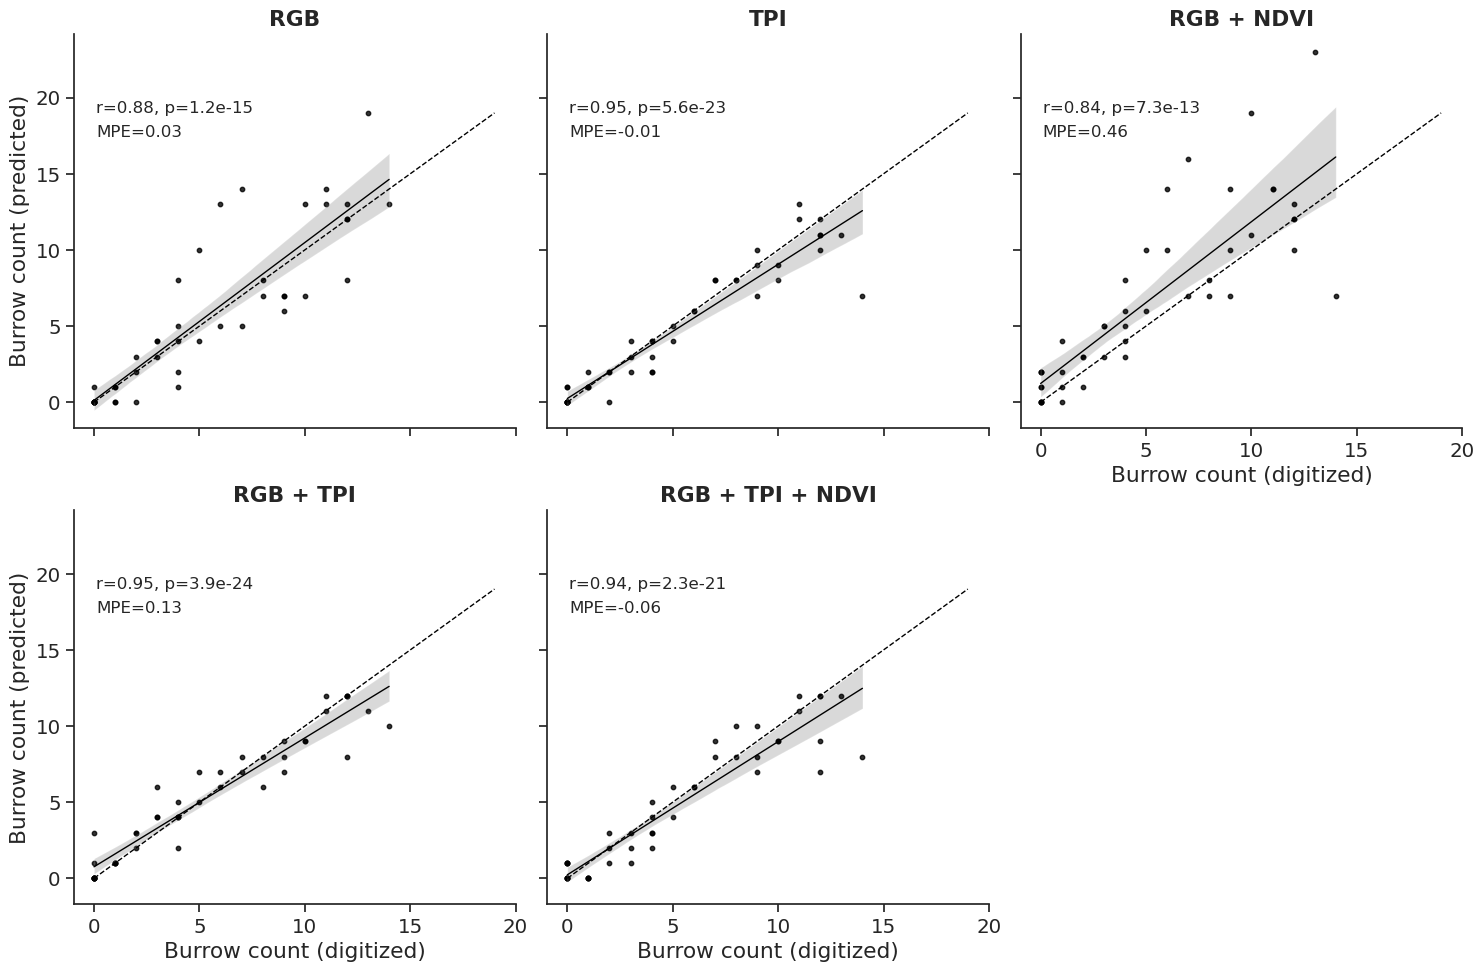

In [18]:
import scipy as sp
sns.set(font_scale = 1.3)
sns.set_style("ticks")
g = sns.lmplot(x='burrow_ct_gt', y='burrow_ct_pred', data=df_burrow_ct.sort_values(['n_inputs', 'inputs']),
               col='inputs', col_wrap=3, 
               scatter_kws={'color': 'black', 's': 10},
               line_kws={'color': 'black', 'linestyle': 'solid', 'linewidth': 1})

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['burrow_ct_gt'], data['burrow_ct_pred'])
    mpe = np.mean((data['burrow_ct_pred'] - data['burrow_ct_gt']) / (data['burrow_ct_gt'].apply(lambda x: max(1, x))))
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=12)
    ax.text(.05, .74, 'MPE={:.2f}'.format(mpe),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
for ax in g.axes:
    ax.plot(np.arange(0, 20), np.arange(0, 20), c='black', linestyle='dashed', linewidth=1)
    ax.set_ylabel('Burrow count (predicted)')
    ax.set_xlabel('Burrow count (digitized)')
    ax.set_xticks(np.arange(0, 21, 5))
    ax.set_yticks(np.arange(0, 21, 5))
    ax.set_title(re.sub('inputs = ', '', ax.get_title()), fontweight='bold')

plt.savefig('./results_figs/burrow_ct_corr.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

In [19]:
len(df_bbox_gt.Tile.unique())

67

In [20]:
len(df_burrow_gt[df_burrow_gt['is_burrow'] == 1].geometry.unique())

282

In [21]:
len(df_burrow_gt[(df_burrow_gt['is_burrow'] == 1) & (df_burrow_gt['activity'] > 0)].geometry.unique())

218

In [22]:
df_burrow_gt_recall = df_burrow_gt.groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['is_burrow'] == 1).sum())

df_burrow_gt_recall.name = 'Recall'
df_burrow_gt_precision = df_burrow_gt.groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['pred'] == 1).sum())

df_burrow_gt_precision.name = 'Precision'
df_burrow_gt_recall_a0 = df_burrow_gt[df_burrow_gt['activity'] != 0].groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['is_burrow'] == 1).sum())#.reset_index(level).rename(columns={0: 'Recall'})

df_burrow_gt_recall_a0.name = 'Recall active'
df_burrow_gt_precision_a0 = df_burrow_gt[df_burrow_gt['activity'] != 0].groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['pred'] == 1).sum())#.reset_index(level).rename(columns={0: 'Recall'})

df_burrow_gt_precision_a0.name = 'Precision active'

In [23]:
df_burrow_gt_smry = pd.merge(df_burrow_gt_precision, pd.merge(df_burrow_gt_recall,
                                       pd.merge(df_burrow_gt_precision_a0, df_burrow_gt_recall_a0, left_index=True, right_index=True),
                                       left_index=True, right_index=True),
         left_index=True, right_index=True).sort_values(['n_inputs', 'inputs'])
df_burrow_gt_smry.insert(2, 'F-score', (2 * df_burrow_gt_smry['Recall'] * df_burrow_gt_smry['Precision']) / (df_burrow_gt_smry['Recall'] + df_burrow_gt_smry['Precision']))
df_burrow_gt_smry['F-score active'] = (2 * df_burrow_gt_smry['Recall active'] * df_burrow_gt_smry['Precision active']) / \
                         (df_burrow_gt_smry['Recall active'] + df_burrow_gt_smry['Precision active'])

In [24]:
df_burrow_gt_smry.round(2)

,,Precision,Recall,F-score,Precision active,Recall active,F-score active
inputs,n_inputs,,,,,,
RGB,1,0.94,0.63,0.75,0.93,0.71,0.81
TPI,1,0.95,0.67,0.78,0.95,0.71,0.81
RGB + NDVI,2,0.92,0.67,0.77,0.91,0.73,0.81
RGB + TPI,2,0.95,0.73,0.83,0.94,0.78,0.85
RGB + TPI + NDVI,3,0.96,0.66,0.78,0.95,0.72,0.82


In [25]:
df_burrow_gt_error = df_burrow_gt.groupby(['n_inputs', 'inputs']).apply(lambda x: ((x['is_burrow'] == 0) & (x['pred'] == 1)).sum() / (x['pred'] == 1).sum())
df_burrow_gt_error.name = 'Error rate'
df_burrow_gt_error = df_burrow_gt_error.reset_index().sort_values(['n_inputs', 'inputs'])
df_burrow_gt_error['Comment'] = 'Overall'
df_burrow_gt_error = pd.pivot(df_burrow_gt_error, index='Comment', columns=['n_inputs', 'inputs'], values='Error rate')
df_burrow_gt_error = df_burrow_gt_error.droplevel(0, axis=1)

In [26]:
df_burrow_gt_nb_error = df_burrow_gt[df_burrow_gt['is_burrow'] == 0].groupby(['inputs', 
                                                                              'n_inputs', 
                                                                              'Comment']).apply(lambda x: ((x['pred'] == 1)).sum() / len(x['pred']))
df_burrow_gt_nb_error.name = 'Error rate'
df_burrow_gt_nb_error = df_burrow_gt_nb_error.reset_index().sort_values(['n_inputs', 'inputs'])
df_burrow_gt_nb_error = pd.pivot(df_burrow_gt_nb_error, index='Comment', columns=['n_inputs', 'inputs'], values='Error rate')
df_burrow_gt_nb_error = df_burrow_gt_nb_error.droplevel(0, axis=1)
df_burrow_gt_nb_error.insert(0, 'n', df_burrow_gt[df_burrow_gt['is_burrow'] == 0]['Comment'].value_counts() // len(df_burrow_gt['inputs'].unique()))

In [27]:
df_burrow_gt_error.insert(0, 'n', df_burrow_gt_nb_error['n'].sum())

In [28]:
df_error_fnl = pd.concat([df_burrow_gt_nb_error, df_burrow_gt_error]).round(2)
df_error_fnl

inputs,n,RGB,TPI,RGB + NDVI,RGB + TPI,RGB + TPI + NDVI
Comment,,,,,,
ant,67,0.07,0.01,0.18,0.03,0.03
den,8,0.38,0.50,0.12,0.50,0.12
dig,6,0.33,0.17,0.17,0.17,0.17
old,27,0.07,0.11,0.07,0.11,0.15
Overall,108,0.06,0.05,0.08,0.05,0.04


In [29]:
len(df_burrow_gt[(df_burrow_gt['is_burrow'] == 1) &
                 (df_burrow_gt['inputs'] == 'RGB') &
                 (df_burrow_gt['pred'].notnull())])

273

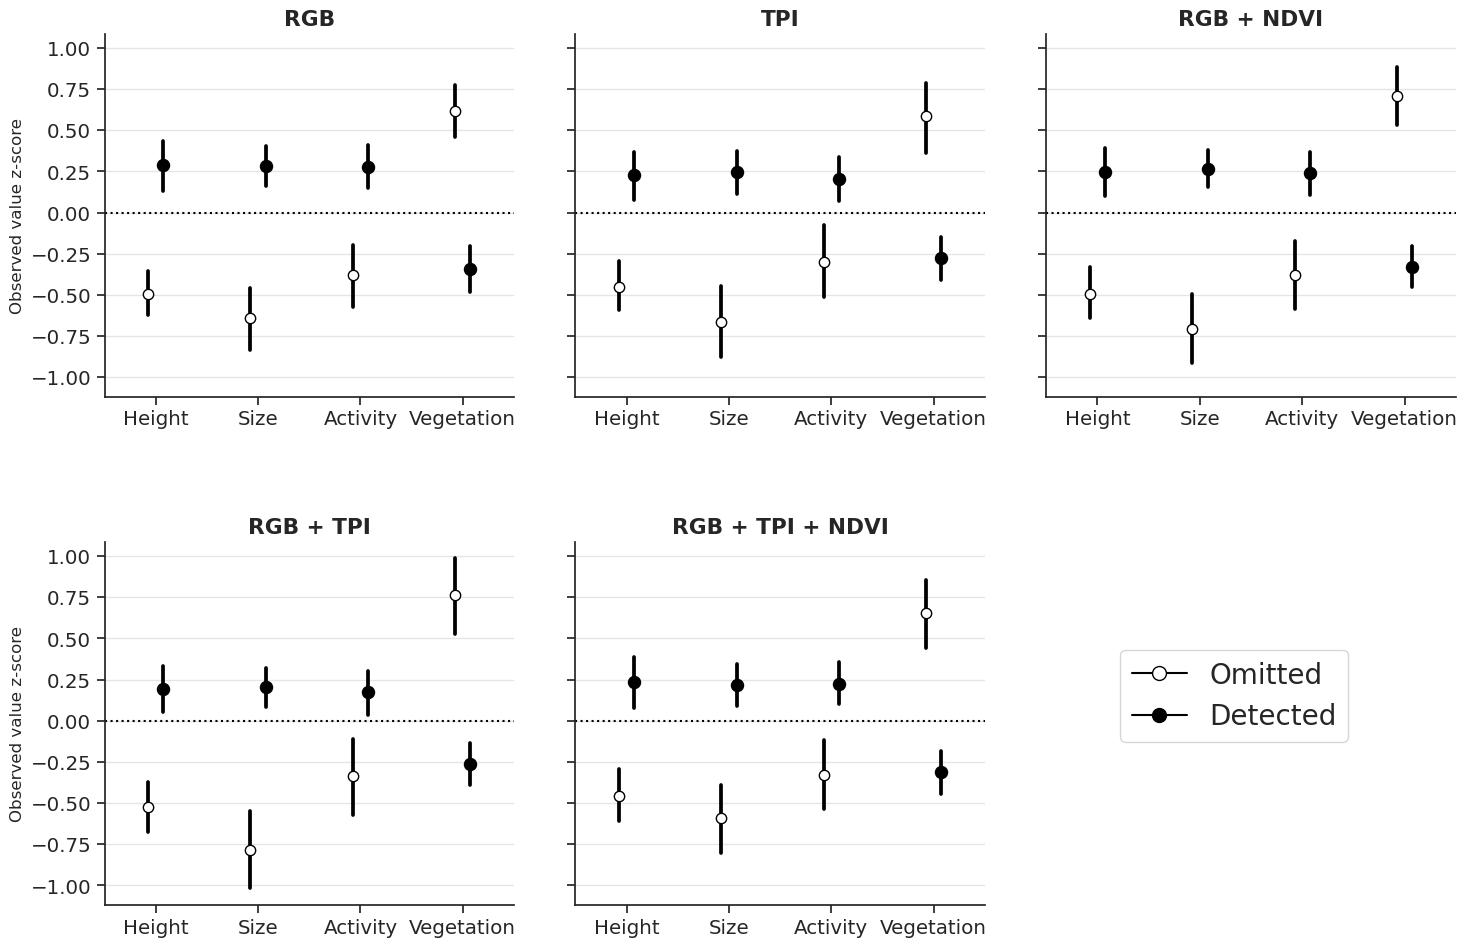

In [30]:
plt.close()
from matplotlib.lines import Line2D
from scipy import stats
sns.set(font_scale = 1.3)
sns.set_style("ticks")
df_burrow_gt_std = df_burrow_gt[df_burrow_gt['is_burrow'] == 1].copy()
df_burrow_gt_std['height'] = stats.zscore(df_burrow_gt_std['height'])
df_burrow_gt_std['size'] = stats.zscore(df_burrow_gt_std['size'])
df_burrow_gt_std['activity'] = stats.zscore(df_burrow_gt_std['activity'])
df_burrow_gt_std['vegetation'] = stats.zscore(df_burrow_gt_std['vegetation'])
df_burrow_gt_long = pd.melt(df_burrow_gt_std,
                               id_vars=['n_inputs', 'inputs', 'Pasture', 'is_burrow', 'pred', 'label'],
                               value_vars=['height', 'size', 'activity', 'vegetation'])
df_burrow_gt_long['inputs'] = df_burrow_gt_long['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))
df_burrow_gt_long['variable'] = df_burrow_gt_long['variable'].apply(lambda x: x.capitalize())
#df_burrow_gt_long.loc[df_burrow_gt_long['variable'] == 'vegetation', 'value'] = 3.0 - df_burrow_gt_long.loc[df_burrow_gt_long['variable'] == 'vegetation', 'value']
g=sns.catplot(x='variable', y='value', data=df_burrow_gt_long.sort_values(['n_inputs', 'inputs']), kind='point',
                hue='pred', col='inputs', col_wrap=3,
                join=False, dodge=0.15, markers='o', scale=1.1, 
              sharex=False,
              palette={0.0: 'black', 1.0: 'black'}, ec=['black', 'none'], legend=False)
for ax in g.axes:
    #ax.set_ylim(0, 3)
    ax.legend().remove()
    p1=ax.get_children()[4]
    p1.set_facecolor('white')
    p1.set_linewidth(1)
    ax.set_xlabel('')
    ax.set_ylabel('Observed value z-score', fontsize=12)
    ax.axhline(y=0, linestyle='dotted', color='black')
    ax.grid(True, axis='y', alpha=0.5)
plt.subplots_adjust(hspace=0.4, wspace=0.15)
legend_elements = [Line2D([0], [0], marker='o', color='black', label='Omitted',
                          markerfacecolor='white', markersize=10),
                  Line2D([0], [0], marker='o', color='black', label='Detected',
                          markerfacecolor='black', markersize=10)]
g.set_titles("{col_name}", weight='bold')  # use this argument literally
g.fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.75, 0.0, 0.25, 0.35), fontsize=20)
plt.savefig('./results_figs/missed_burrow_characteristics_zscore.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

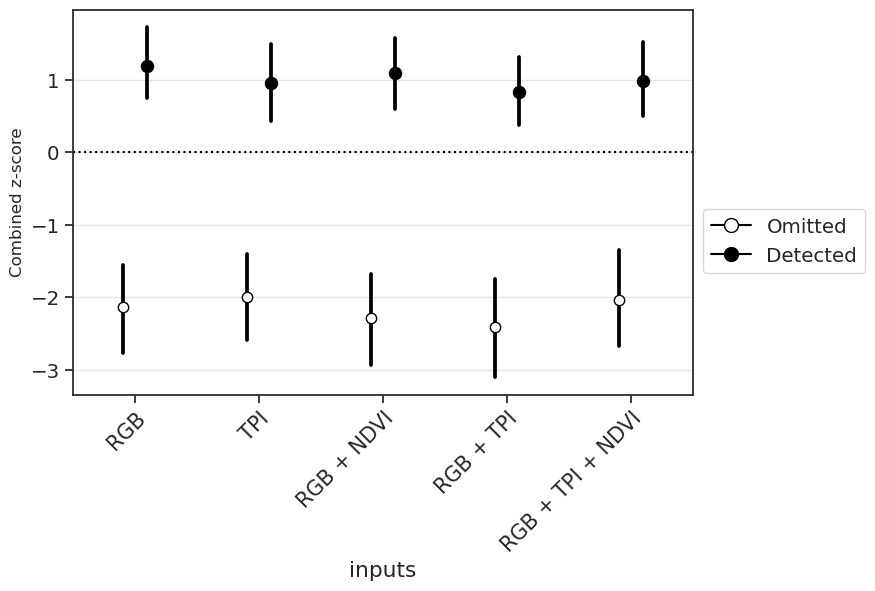

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
df_burrow_gt_std['score'] = df_burrow_gt_std.apply(lambda x: x['height'] + x['size'] + x['activity'] + (-1.0 * x['vegetation']), axis=1)
sns.pointplot(x='inputs', y='score', data=df_burrow_gt_std.sort_values(['n_inputs', 'inputs']),
            hue='pred', ax=ax, dodge=0.2, join=False, ci=99, markers='o', scale=1.1, 
              palette={0.0: 'black', 1.0: 'black'}, fc=['white', 'black'], ec=['black', 'none'])
ax.legend().remove()
ax.axhline(y=0, linestyle='dotted', color='black')
p1=ax.get_children()[5]
p1.set_facecolor('white')
p1.set_linewidth(1)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=15)
legend_elements = [Line2D([0], [0], marker='o', color='black', label='Omitted',
                          markerfacecolor='white', markersize=10),
                  Line2D([0], [0], marker='o', color='black', label='Detected',
                          markerfacecolor='black', markersize=10)]
ax.set_ylabel('Combined z-score', fontsize=12)
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.9, 0.0, 0.5, 0.5))
ax.grid(True, axis='y', alpha=0.5)
plt.savefig('./results_figs/missed_burrow_characteristics_zscore_comb.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

In [32]:
df_bbox_gt = df_bbox_gt[df_bbox_gt['Type'] != 'non_burrows'].copy()

In [33]:
def val_metrics(df, prefix='pred'):
    #(group_label, df) = grouping
    precision = df[prefix + '_correct_ct'].sum() / df[prefix + '_ct'].sum()
    recall = df[prefix + '_correct_ct'].sum() / df['gt_ct'].sum()
    fscore = (2 * precision * recall) / (precision + recall)
    if len(df.name) == 1:
        return pd.DataFrame({'Precision': precision,
                             'Recall': recall,
                             'F-score': fscore},
                            index=[len(df.name.split('_'))])
    else:
        return pd.DataFrame({'Precision': precision,
                             'Recall': recall,
                             'F-score': fscore},
                            index=[len(df.name[0].split('_'))])
#df_bbox.groupby('inputs').apply(val_metrics)

In [34]:
df_bbox_gt_pred_smry = df_bbox_gt[df_bbox_gt['Digitize'] == 1].groupby(['inputs', 'n_inputs']).apply(val_metrics).reset_index().rename(columns={'level_1': 'n_inputs'}).sort_values('n_inputs')
df_bbox_gt_label_smry = df_bbox_gt[df_bbox_gt['Digitize'] == 1].groupby(['inputs', 'n_inputs']).apply(val_metrics, prefix='label').reset_index().rename(columns={'level_1': 'n_inputs'}).sort_values('n_inputs')

In [35]:
df_bbox_gt_label_smry.round(2)

,inputs,n_inputs,level_2,Precision,Recall,F-score
0,RGB,1,1,0.78,0.77,0.77
4,TPI,1,1,0.78,0.77,0.77
1,RGB + NDVI,2,1,0.78,0.77,0.77
2,RGB + TPI,2,1,0.78,0.77,0.77
3,RGB + TPI + NDVI,3,1,0.78,0.77,0.77


In [36]:
len(df_bbox_gt[df_bbox_gt['Digitize'] == 1]['Tile'].unique())

13

In [37]:
df_bbox_gt[df_bbox_gt['Digitize'] == 1].groupby('Tile').first().reset_index()['gt_ct'].sum()

47.0

In [38]:
df_bbox_gt_pred_smry.round(2).sort_values('F-score', ascending=False)

,inputs,n_inputs,level_2,Precision,Recall,F-score
2,RGB + TPI,2,1,0.84,0.79,0.82
4,TPI,1,1,0.86,0.72,0.79
3,RGB + TPI + NDVI,3,1,0.85,0.72,0.78
1,RGB + NDVI,2,1,0.64,0.75,0.69
0,RGB,1,1,0.67,0.68,0.67


In [39]:
df_bbox_gt[df_bbox_gt['Digitize'] == 1].sort_values('ID')

,ID,n_inputs,Pasture,Tile,min_x,min_y,Type,Train,Digitize,Poly_ID,...,max_y,img_group,path_pre,pred_ct,pred_correct_ct,label_ct,label_correct_ct,gt_ct,model,inputs
1,22E_12,1,22E,burrows_active_1,520413.0,4518317.0,burrows_active,0,1,22e,...,4518347.0,group_2,train_tiles/22E_burrows_active/22E_burrows_act...,7.0,2.0,3.0,1.0,3.0,deeplabplus,RGB
1,22E_12,1,22E,burrows_active_1,520413.0,4518317.0,burrows_active,0,1,22e,...,4518347.0,group_2,train_tiles/22E_burrows_active/22E_burrows_act...,1.0,1.0,3.0,1.0,3.0,deeplabplus,TPI
1,22E_12,2,22E,burrows_active_1,520413.0,4518317.0,burrows_active,0,1,22e,...,4518347.0,group_2,train_tiles/22E_burrows_active/22E_burrows_act...,5.0,2.0,3.0,1.0,3.0,deeplabplus,RGB + NDVI
1,22E_12,2,22E,burrows_active_1,520413.0,4518317.0,burrows_active,0,1,22e,...,4518347.0,group_2,train_tiles/22E_burrows_active/22E_burrows_act...,3.0,2.0,3.0,1.0,3.0,deeplabplus,RGB + TPI
1,22E_12,3,22E,burrows_active_1,520413.0,4518317.0,burrows_active,0,1,22e,...,4518347.0,group_2,train_tiles/22E_burrows_active/22E_burrows_act...,2.0,2.0,3.0,1.0,3.0,deeplabplus,RGB + TPI + NDVI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,CN_50,2,CN,burrows_active_23,519827.0,4516681.0,burrows_active,0,1,cn2,...,4516711.0,group_3,train_tiles/CN_burrows_active/CN_burrows_activ...,0.0,0.0,0.0,0.0,0.0,deeplabplus,RGB + NDVI
91,CN_50,2,CN,burrows_active_23,519827.0,4516681.0,burrows_active,0,1,cn2,...,4516711.0,group_3,train_tiles/CN_burrows_active/CN_burrows_activ...,0.0,0.0,0.0,0.0,0.0,deeplabplus,RGB + TPI
91,CN_50,1,CN,burrows_active_23,519827.0,4516681.0,burrows_active,0,1,cn2,...,4516711.0,group_3,train_tiles/CN_burrows_active/CN_burrows_activ...,0.0,0.0,0.0,0.0,0.0,deeplabplus,RGB
91,CN_50,3,CN,burrows_active_23,519827.0,4516681.0,burrows_active,0,1,cn2,...,4516711.0,group_3,train_tiles/CN_burrows_active/CN_burrows_activ...,0.0,0.0,0.0,0.0,0.0,deeplabplus,RGB + TPI + NDVI


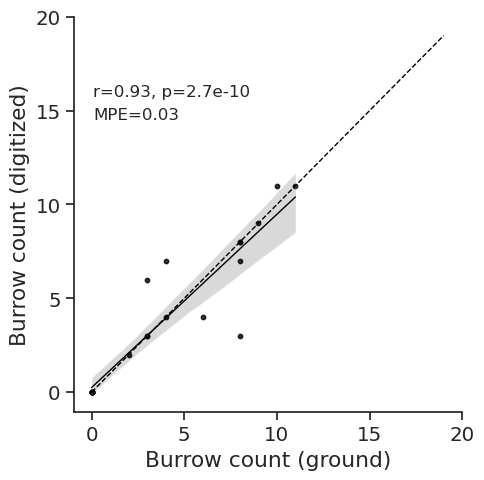

In [40]:
sns.set(font_scale = 1.3)
sns.set_style("ticks")
g = sns.lmplot(x='gt_ct', y='label_ct', data=df_bbox_gt[df_bbox_gt['Digitize'] == 1].groupby('ID').first().reset_index(), 
               scatter_kws={'color': 'black', 's': 10},
               line_kws={'color': 'black', 'linestyle': 'solid', 'linewidth': 1})
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['label_ct'], data['gt_ct'])
    mpe = np.mean((data['label_ct'] - data['gt_ct']) / (data['gt_ct'].apply(lambda x: max(1, x))))
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=12)
    ax.text(.05, .74, 'MPE={:.2f}'.format(mpe),
            transform=ax.transAxes, fontsize=12)

g.map_dataframe(annotate)
for ax in g.axes[0]:
    ax.plot(np.arange(0, 20), np.arange(0, 20), c='black', linestyle='dashed', linewidth=1)
    ax.set_ylabel('Burrow count (digitized)')
    ax.set_xlabel('Burrow count (ground)')
    ax.set_xticks(np.arange(0, 21, 5))
    ax.set_yticks(np.arange(0, 21, 5))
    ax.set_title(re.sub('inputs = ', '', ax.get_title()), fontweight='bold')
plt.savefig('./results_figs/Supp_burrow_ct_digitized_vs_ground.png', dpi=300)
plt.show()

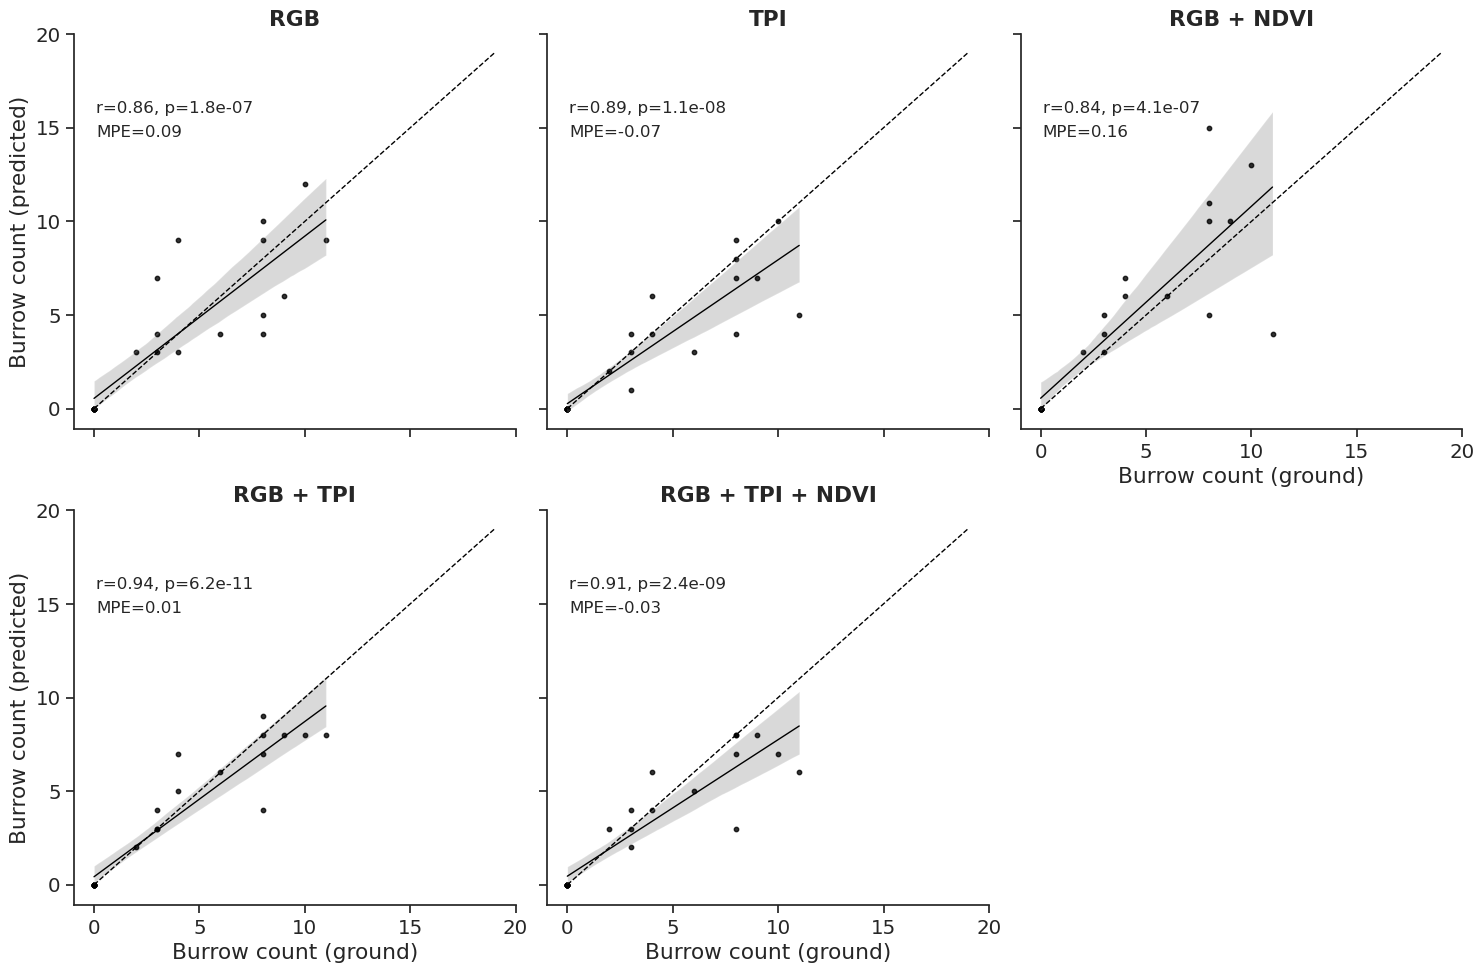

In [41]:
g = sns.lmplot(x='gt_ct', y='pred_ct', data=df_bbox_gt[df_bbox_gt['Digitize'] == 1].sort_values(['n_inputs', 'inputs']),
               col='inputs', col_wrap=3, 
               scatter_kws={'color': 'black', 's': 10},
               line_kws={'color': 'black', 'linestyle': 'solid', 'linewidth': 1})

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['pred_ct'], data['gt_ct'])
    mpe = np.mean((data['pred_ct'] - data['gt_ct']) / (data['gt_ct'].apply(lambda x: max(1, x))))
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=12)
    ax.text(.05, .74, 'MPE={:.2f}'.format(mpe),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
for ax in g.axes:
    ax.plot(np.arange(0, 20), np.arange(0, 20), c='black', linestyle='dashed', linewidth=1)
    ax.set_ylabel('Burrow count (predicted)')
    ax.set_xlabel('Burrow count (ground)')
    ax.set_xticks(np.arange(0, 21, 5))
    ax.set_yticks(np.arange(0, 21, 5))
    ax.set_title(re.sub('inputs = ', '', ax.get_title()), fontweight='bold')
plt.savefig('./results_figs/Supp_burrow_ct_predicted_vs_ground_only_digitized.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
df_downscaled_test = pd.read_csv('./cnn_test_results_downscaled/downscaled_model_test_validation.csv')

In [43]:
df_downscaled_test['inputs'] = df_downscaled_test['inputs'].apply(lambda x: re.sub(',', ' + ', x.upper()))

In [44]:
df_valid_burrow['test_resolution'] = 2.0

In [45]:
#df_downscaled_test = pd.concat([df_downscaled_test, df_valid_burrow])

In [46]:
df_downscaled_test['inputs'] = pd.Categorical(df_downscaled_test['inputs'],
                                              categories=['RGB', 'TPI', 'RGB + NDVI', 'RGB + TPI', 'RGB + TPI + NDVI'],
                                              ordered=True)
df_downscaled_test['test_resolution'] = df_downscaled_test['test_resolution'].astype(int)

In [48]:
df_downscaled_test.sort_values(['model_resolution', 'inputs']).round(2).to_csv('./results_tables/appendix_full_test_valid_results.csv', index=False)

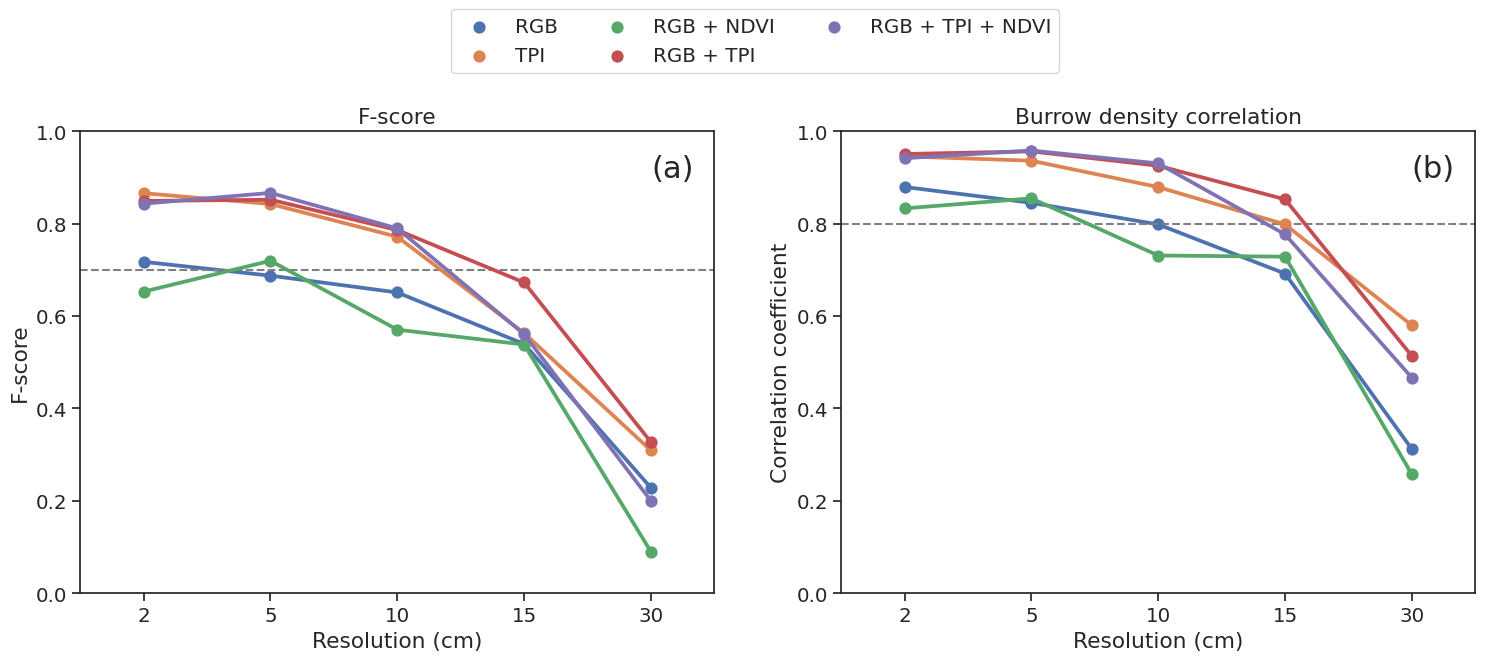

In [49]:
sns.set(font_scale = 1.3)
sns.set_style("ticks")
fig, axs = plt.subplots(figsize=(18, 6), ncols=2)
sns.pointplot(x='test_resolution', y='fscore', 
            hue='inputs', hue_order=['RGB', 'TPI', 'RGB + NDVI', 
                                     'RGB + TPI', 'RGB + TPI + NDVI'],
            data=df_downscaled_test.sort_values('model_resolution'),
            ci=None,
            ax=axs[0], show_legend=False, zorder=10)
#sns.pointplot(x='test_resolution', y='fscore', 
#            hue='inputs',
#            data=df_best_downscaled_test.sort_values('test_resolution'),
#            ci=None,
#            ax=axs[0], show_legend=False,
#            linestyles='dotted')
axs[0].set_title('F-score')
axs[0].set_ylabel('F-score')
axs[0].axhline(y=0.70, linestyle='dashed', color='grey', zorder=1)
axs[0].text(x=4, y=0.90, s='(a)', fontsize=22)

sns.pointplot(x='test_resolution', y='correlation', 
            hue='inputs', hue_order=['RGB', 'TPI', 'RGB + NDVI', 
                                     'RGB + TPI', 'RGB + TPI + NDVI'],
            data=df_downscaled_test.sort_values('test_resolution'),
            ci=None,
            ax=axs[1], show_legend=False, zorder=10)
#sns.pointplot(x='test_resolution', y='correlation', 
#            hue='inputs',
#            data=df_best_downscaled_test.sort_values('test_resolution'),
#            ci=None,
#            ax=axs[1], show_legend=False,
#            linestyles='dotted')
axs[1].set_title('Burrow density correlation')
axs[1].set_ylabel('Correlation coefficient')
axs[1].axhline(y=0.80, linestyle='dashed', color='grey', zorder=1)
axs[1].text(x=4, y=0.90, s='(b)', fontsize=22)

for ax in axs:
    ax.set_xlabel('Resolution (cm)')
    ax.legend().remove()
    ax.set_ylim((0, 1.0))
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0, 0, 1.0, 1.1), ncol=3)
plt.savefig('./results_figs/cnn_results_downscaled_test_validation.png',
            dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [50]:
df_burrow_gt_ds = pd.DataFrame(columns=df_burrow_gt.columns.to_list())
gt_LIST = glob.glob('./cnn_test_results_downscaled/test_valid_burrow_gt*.csv')
for f in tqdm(gt_LIST):
    df_burrow_gt_tmp = pd.read_csv(f)
    df_burrow_gt_tmp['inputs'] = pd.Categorical(df_burrow_gt_tmp['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper())),
                                                categories=['RGB', 'TPI', 'RGB + NDVI', 'RGB + TPI', 'RGB + TPI + NDVI'],
                                                ordered=True)
    df_burrow_gt_ds = pd.concat([df_burrow_gt_ds, df_burrow_gt_tmp])

100%|██████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 62.62it/s]


In [51]:
df_burrow_gt_error_ds = df_burrow_gt_ds.groupby(['inputs', 'resolution']).apply(lambda x: ((x['is_burrow'] == 0) & (x['pred'] == 1)).sum() / (x['pred'] == 1).sum())
df_burrow_gt_error_ds.name = 'Error rate'
df_burrow_gt_error_ds = df_burrow_gt_error_ds.reset_index().sort_values(['inputs', 'resolution'])
df_burrow_gt_error_ds['Comment'] = 'Overall'
df_burrow_gt_error_ds = pd.pivot(df_burrow_gt_error_ds, index=['resolution', 'Comment'], columns=['inputs'], values='Error rate')
#df_burrow_gt_error_ds = df_burrow_gt_error_ds.droplevel(0, axis=1)

In [52]:
df_burrow_gt_error_ds

,inputs,RGB,TPI,RGB + NDVI,RGB + TPI,RGB + TPI + NDVI
resolution,Comment,,,,,
2.0,Overall,0.061111,0.050251,0.086957,0.046948,0.031915
5.0,Overall,0.058394,0.059701,0.028369,0.049505,0.037915
10.0,Overall,0.118280,0.042945,0.047619,0.034682,0.028902
15.0,Overall,0.113821,0.061224,0.135135,0.030534,0.055556
30.0,Overall,0.192308,0.085366,0.000000,0.116667,0.209302


In [53]:
df_burrow_gt_nb_error_ds = df_burrow_gt_ds[df_burrow_gt_ds['is_burrow'] == 0].groupby(['inputs', 
                                                                              'resolution', 
                                                                              'Comment']).apply(lambda x: ((x['pred'] == 1)).sum() / len(x['pred']))
df_burrow_gt_nb_error_ds.name = 'Error rate'
df_burrow_gt_nb_error_ds = df_burrow_gt_nb_error_ds.reset_index().sort_values(['inputs', 'resolution'])
df_burrow_gt_nb_error_ds = pd.pivot(df_burrow_gt_nb_error_ds, index=['resolution', 'Comment'], columns=['inputs'], values='Error rate')
#df_burrow_gt_nb_error_ds = df_burrow_gt_nb_error_ds.droplevel(0, axis=1)
df_burrow_gt_nb_error_ds.insert(0, 'n', df_burrow_gt_ds[df_burrow_gt_ds['is_burrow'] == 0].groupby('resolution')['Comment'].value_counts() // len(df_burrow_gt_ds['inputs'].unique()))

In [54]:
#df_burrow_gt_nb_error_ds

In [55]:
df_burrow_gt_error_ds.insert(0, 'n', df_burrow_gt_nb_error_ds.loc[2.0]['n'].sum())

In [56]:
df_burrow_gt_nb_error_ds.loc[2.0]

inputs,n,RGB,TPI,RGB + NDVI,RGB + TPI,RGB + TPI + NDVI
Comment,,,,,,
ant,67,0.074627,0.014925,0.194030,0.029851,0.029851
den,8,0.375000,0.500000,0.125000,0.500000,0.125000
dig,6,0.166667,0.166667,0.166667,0.166667,0.166667
old,27,0.074074,0.148148,0.037037,0.111111,0.074074


In [57]:
df_burrow_gt_error_ds

,inputs,n,RGB,TPI,RGB + NDVI,RGB + TPI,RGB + TPI + NDVI
resolution,Comment,,,,,,
2.0,Overall,108,0.061111,0.050251,0.086957,0.046948,0.031915
5.0,Overall,108,0.058394,0.059701,0.028369,0.049505,0.037915
10.0,Overall,108,0.118280,0.042945,0.047619,0.034682,0.028902
15.0,Overall,108,0.113821,0.061224,0.135135,0.030534,0.055556
30.0,Overall,108,0.192308,0.085366,0.000000,0.116667,0.209302


In [58]:
df_error_fnl = pd.concat([df_burrow_gt_nb_error_ds, df_burrow_gt_error_ds]).round(2)
df_error_fnl.index = df_error_fnl.index.set_levels(pd.CategoricalIndex([x.capitalize() for x in df_error_fnl.index.levels[1].to_list()],
                                                             categories=['Ant', 'Den', 'Dig', 'Old', 'Overall'], ordered=True),
                                         level=1)
df_error_fnl = df_error_fnl.sort_index()

In [59]:
df_error_fnl.to_csv('./results_tables/appendix_gt_commission_error_all.csv')

## Colony scale results

In [77]:
col_val_list = glob.glob('cnn_test_results_downscaled/downscaled_colony*')

In [78]:
for idx, f in enumerate(col_val_list):
    if idx == 0:
        df_col_val = pd.read_csv(f)
    else:
        df_col_val = pd.concat([df_col_val, pd.read_csv(f)])
#df_col_val['resolution'] = df_col_val['resolution'].apply(lambda x: int(re.sub('cm', '', x)))

In [79]:
df_col_april = pd.read_csv('./ground_data/historical/summaries/pDog_2021_April_summary.csv')
df_col_2020 = pd.read_csv('./ground_data/historical/summaries/pDog_2020_summary.csv')

In [80]:
df_col_val['ha_diff'] = df_col_val['ha_pred'] - df_col_val['ha_obs']
df_col_val['ha_diff_july'] = df_col_val['ha_pred_july'] - df_col_val['ha_obs_july']

In [81]:
df_col_val['inputs'] = pd.Categorical(df_col_val['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper())),
                                                categories=['RGB', 'TPI', 'RGB + TPI', 'RGB + TPI + NDVI'],
                                                ordered=True)

In [82]:
df_core_5cm = df_col_val[(df_col_val['conn_thresh'] == 3) & (df_col_val['yrs_thresh'] == 0) & (df_col_val['resolution'] == '5cm')].reset_index().sort_values('Pasture')
df_core_5cm['ha_diff_pct']=df_core_5cm['ha_diff'] / df_core_5cm['ha_obs']
df_core_5cm[['Pasture', 'inputs', 'jscore_july', 'ha_pred_july', 'ha_obs_july', 'ha_diff_july',
             'jscore', 'ha_pred', 'ha_obs', 'ha_diff']].sort_values(['Pasture', 'inputs']).round(2).to_csv(
    './results_tables/appendix_full_colony_valid_5cm.csv', index=False)#[df_core_5cm['inputs'].isin(['RGB + TPI', 'RGB', 'TPI'])]

In [143]:
df_core_10cm = df_col_val[(df_col_val['conn_thresh'] == 3) & (df_col_val['yrs_thresh'] == 0) & (df_col_val['resolution'] == '10cm')].reset_index().sort_values('Pasture')
df_core_10cm['ha_diff_pct']=df_core_10cm['ha_diff'] / df_core_10cm['ha_obs']
df_core_10cm[['Pasture', 'inputs', 'jscore_july', 'ha_pred_july', 'ha_obs_july', 'ha_diff_july',
             'jscore', 'ha_pred', 'ha_obs', 'ha_diff']].sort_values(['Pasture', 'inputs']).round(2).to_csv(
    './results_tables/appendix_full_colony_valid_10cm.csv', index=False)#[df_core_5cm['inputs'].isin(['RGB + TPI', 'RGB', 'TPI'])]

In [83]:
df_core_5cm[(df_core_5cm['Pasture'] != '29-30')].groupby(['resolution',
                                                          'inputs'])['ha_diff'].sum()

resolution  inputs          
5cm         RGB                 -19.6550
            TPI                 220.0425
            RGB + TPI           159.7600
            RGB + TPI + NDVI    172.6325
Name: ha_diff, dtype: float64

In [84]:
#df_core_5cm[(df_core_5cm['Pasture'] != '29-30')].groupby(['resolution',
#                                                          'inputs']).apply(lambda x: np.average(abs(x['ha_diff_pct']), weights=x['ha_pred']))# /\
#df_col_val[(df_col_val['conn_thresh'] == 3) & (df_col_val['yrs_thresh'] == 0) & (df_col_val['Pasture'] != '29-30')].groupby(['resolution',
 #                                                                                      'inputs'])['ha_obs'].sum()
df_core_5cm[(df_core_5cm['Pasture'] != '29-30')].groupby(['resolution',
                                                          'inputs']).apply(lambda x: np.sum(abs(x['ha_diff'])/x['ha_obs'].sum()))

resolution  inputs          
5cm         RGB                 0.134837
            TPI                 0.326024
            RGB + TPI           0.236707
            RGB + TPI + NDVI    0.255779
dtype: float64

In [85]:
df_col_val_diff_smry_sep = df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                     (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(abs(x['ha_diff'])/x['ha_obs'].sum()))
df_col_val_diff_smry_sep.name = 'ha_diff_pct_all'
df_col_val_diff_smry_sep = pd.DataFrame(df_col_val_diff_smry_sep)

In [86]:
df_col_val_diff_smry_sep['ha_diff_sum_all'] = df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                                         (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(x['ha_diff']))
df_col_val_diff_smry_sep['ha_diff_abs_all'] = df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                                         (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(abs(x['ha_diff'])))
df_col_val_diff_smry_sep['ha_diff_pct_active'] =  df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                                             (df_col_val['yrs_thresh'] == 0) &
                                                         (df_col_val['Pasture'] != '29-30')].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(abs(x['ha_diff'])/x['ha_obs'].sum()))
df_col_val_diff_smry_sep['ha_diff_sum_active'] = df_col_val[(df_col_val['conn_thresh'] == 3) &
                                                            (df_col_val['yrs_thresh'] == 0) &
                                                         (df_col_val['Pasture'] != '29-30')].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(x['ha_diff']))
df_col_val_diff_smry_sep['ha_diff_abs_active'] = df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                                            (df_col_val['yrs_thresh'] == 0) &
                                                         (df_col_val['Pasture'] != '29-30')].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(abs(x['ha_diff'])))


In [87]:
df_col_val_diff_smry_sep = df_col_val_diff_smry_sep.reset_index()
df_col_val_diff_smry_sep['resolution'] = pd.Categorical(df_col_val_diff_smry_sep['resolution'], ['5cm', '10cm', '15cm'], ordered=True)
df_col_val_diff_smry_sep.sort_values(['resolution', 'inputs']).round(2)[['resolution', 'inputs',
                                                                         'ha_diff_sum_all', 'ha_diff_abs_all', 'ha_diff_pct_all',
                                                                         'ha_diff_sum_active', 'ha_diff_abs_active', 'ha_diff_pct_active']].to_csv(
'./results_tables/appendix_sept_colony_ha_diff.csv', index=False)

In [88]:
df_col_val_diff_summary = df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                     (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(abs(x['ha_diff'])/x['ha_obs'].sum()))
df_col_val_diff_summary.name = 'ha_diff_pct_sept'
df_col_val_diff_summary = pd.DataFrame(df_col_val_diff_summary)

In [89]:
df_col_val_diff_summary['ha_diff_sum_sept'] = df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                     (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(x['ha_diff']))
df_col_val_diff_summary['ha_diff_abs_sept'] = df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                     (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(abs(x['ha_diff'])))
df_col_val_diff_summary['ha_diff_pct_june'] = df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                     (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(abs(x['ha_diff_july'])/x['ha_obs_july'].sum()))
df_col_val_diff_summary['ha_diff_sum_june'] = df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                     (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(x['ha_diff_july']))
df_col_val_diff_summary['ha_diff_abs_june'] = df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                     (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                                               'inputs']).apply(lambda x: np.sum(abs(x['ha_diff_july'])))

In [90]:
df_col_val_diff_summary

ha_diff_pct_sept  ha_diff_sum_sept  \
resolution inputs                                                 
10cm       RGB                       0.250509           61.1200   
           TPI                       0.126764          -13.0225   
           RGB + TPI                 0.226901          -43.8850   
           RGB + TPI + NDVI          0.180352          -88.5600   
15cm       RGB                       0.618242         -177.5250   
           TPI                       0.185902          -16.4700   
           RGB + TPI                 0.399682         -118.3025   
           RGB + TPI + NDVI          0.842694         -262.6925   
5cm        RGB                       0.188803           16.9000   
           TPI                       0.502327          339.3850   
           RGB + TPI                 0.370050          250.0150   
           RGB + TPI + NDVI          0.403811          272.8250   

                             ha_diff_abs_sept  ha_diff_pct_june  \
resolution inputs                                                 
10cm       RGB                        84.6250          0.878630   
           TPI                        42.8225          0.445406   
           RGB + TPI                  76.6500          0.704190   
           RGB + TPI + NDVI          121.8500          0.694477   
15cm       RGB                       208.8500          0.901984   
           TPI                        62.8000          0.455852   
           RGB + TPI                 135.0175          0.785903   
           RGB + TPI + NDVI          284.6725          0.967399   
5cm        RGB                       127.5600          0.369563   
           TPI                       339.3850          0.170318   
           RGB + TPI                 250.0150          0.172666   
           RGB + TPI + NDVI          272.8250          0.131122   

                             ha_diff_sum_june  ha_diff_abs_june  
resolution inputs                                                
10cm       RGB                      -182.5450          348.0100  
           TPI                      -176.4175          176.4175  
           RGB + TPI                -278.9175          278.9175  
           RGB + TPI + NDVI         -548.4500          550.1400  
15cm       RGB                      -340.5950          357.2600  
           TPI                      -179.0750          180.5550  
           RGB + TPI                -311.2825          311.2825  
           RGB + TPI + NDVI         -383.1700          383.1700  
5cm        RGB                      -280.1250          292.7550  
           TPI                        50.3400          134.9200  
           RGB + TPI                 -69.0650          136.7800  
           RGB + TPI + NDVI          -46.1650          103.8700

In [91]:
df_col_val[(df_col_val['conn_thresh'] == 3) & (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                                                        'inputs'])['ha_diff'].sum()

resolution  inputs          
10cm        RGB                  61.1200
            TPI                 -13.0225
            RGB + TPI           -43.8850
            RGB + TPI + NDVI    -88.5600
15cm        RGB                -177.5250
            TPI                 -16.4700
            RGB + TPI          -118.3025
            RGB + TPI + NDVI   -262.6925
5cm         RGB                  16.9000
            TPI                 339.3850
            RGB + TPI           250.0150
            RGB + TPI + NDVI    272.8250
Name: ha_diff, dtype: float64

In [92]:
df_core_5cm[(df_core_5cm['Pasture'] != '29-30')].groupby(['resolution',
                                                          'inputs']).apply(lambda x: np.sum(abs(x['ha_diff_july'])/x['ha_obs_july'].sum()))

resolution  inputs          
5cm         RGB                 0.366148
            TPI                 0.086034
            RGB + TPI           0.132615
            RGB + TPI + NDVI    0.095672
dtype: float64

In [93]:
df_col_val[(df_col_val['conn_thresh'] == 3) & 
           (df_col_val['yrs_thresh'] == 0)].groupby(['resolution',
                                                     'inputs']).apply(lambda x: np.sum(abs(x['ha_diff_july'])/x['ha_obs_july'].sum()))

resolution  inputs          
10cm        RGB                 0.878630
            TPI                 0.445406
            RGB + TPI           0.704190
            RGB + TPI + NDVI    0.694477
15cm        RGB                 0.901984
            TPI                 0.455852
            RGB + TPI           0.785903
            RGB + TPI + NDVI    0.967399
5cm         RGB                 0.369563
            TPI                 0.170318
            RGB + TPI           0.172666
            RGB + TPI + NDVI    0.131122
dtype: float64

In [94]:
df_col_val_jscore_long = pd.melt(df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                          (df_col_val['yrs_thresh'] == 0) &
                                          (df_col_val['Pasture'] != 'Total')], 
                                 id_vars=['Pasture', 'resolution', 'inputs'],
                                 value_vars=['jscore', 'jscore_july'], 
                                 var_name='Season',
                                 value_name='J-score')
df_col_val_jscore_long['Season'] = df_col_val_jscore_long['Season'].apply(lambda x: 'July' if 'july' in x else 'September')
df_col_val_jscore_long['Season'] = pd.Categorical(df_col_val_jscore_long['Season'], ['July', 'September'], ordered=True)

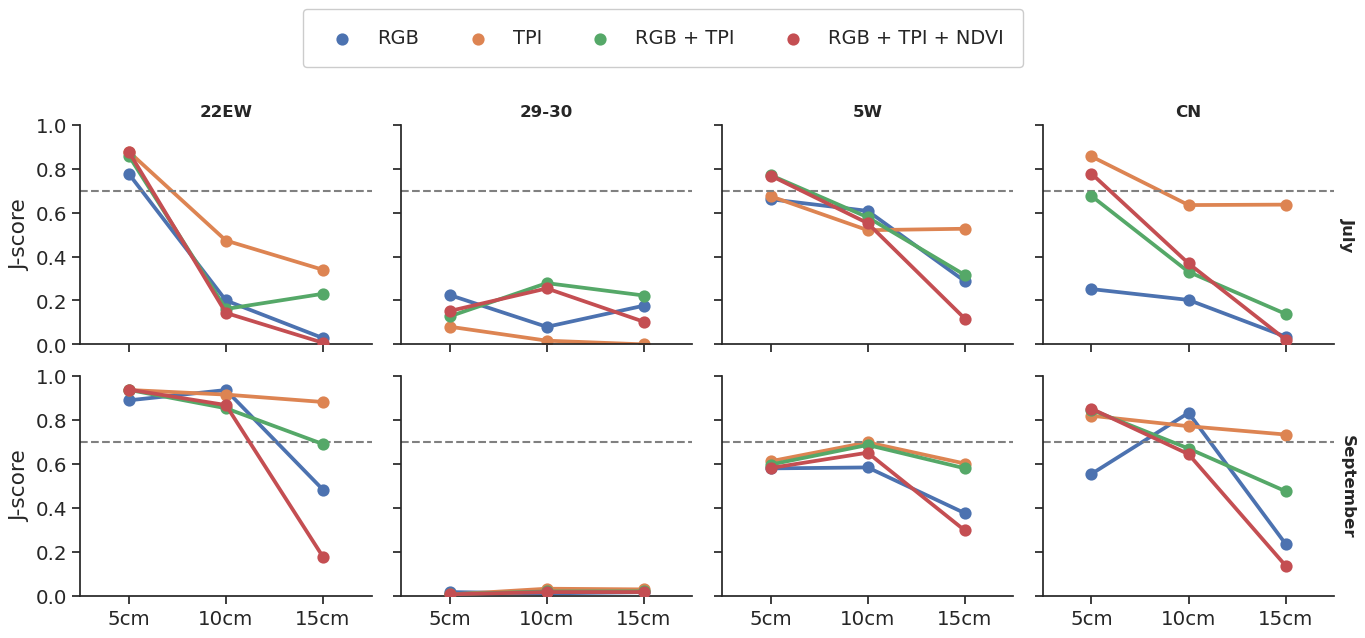

In [95]:
#fig, axs
g1 = sns.catplot(data=df_col_val_jscore_long,
                 kind='point',
                 hue='inputs', col='Pasture', row='Season', height=3, aspect=1.25,
                    x='resolution', y='J-score', 
                    order=['5cm', '10cm', '15cm'], ci=None, join=True, legend=False, margin_titles=True)
g1.set_titles(col_template="{col_name}", row_template="{row_name}", weight='bold', size=12)  # use this argument literally
g1.set_axis_labels(y_var='J-score', x_var='')
g1.add_legend(bbox_to_anchor=(0.5, 1), loc='lower right', borderpad=1, frameon=True,
    framealpha=1.0, fontsize=14, ncol=4)
for ax in g1.axes.flatten():
    ax.set_ylim((0, 1.0))
    ax.axhline(y=0.70, linestyle='dashed', color='grey')
plt.savefig('./results_figs/jscore_colony_pasture_season.png', bbox_inches='tight', dpi=300)
plt.show()

In [96]:
df_col_val_diff_long = pd.melt(df_col_val[(df_col_val['conn_thresh'] == 3) & 
                                          (df_col_val['yrs_thresh'] == 0) &
                                          (df_col_val['Pasture'] != 'Total')], 
                                 id_vars=['Pasture', 'resolution', 'inputs'],
                                 value_vars=['ha_diff', 'ha_diff_july'], 
                                 var_name='Season',
                                 value_name='diff')
df_col_val_diff_long['Season'] = df_col_val_diff_long['Season'].apply(lambda x: 'July' if 'july' in x else 'September')
df_col_val_diff_long['Season'] = pd.Categorical(df_col_val_diff_long['Season'], ['July', 'September'], ordered=True)

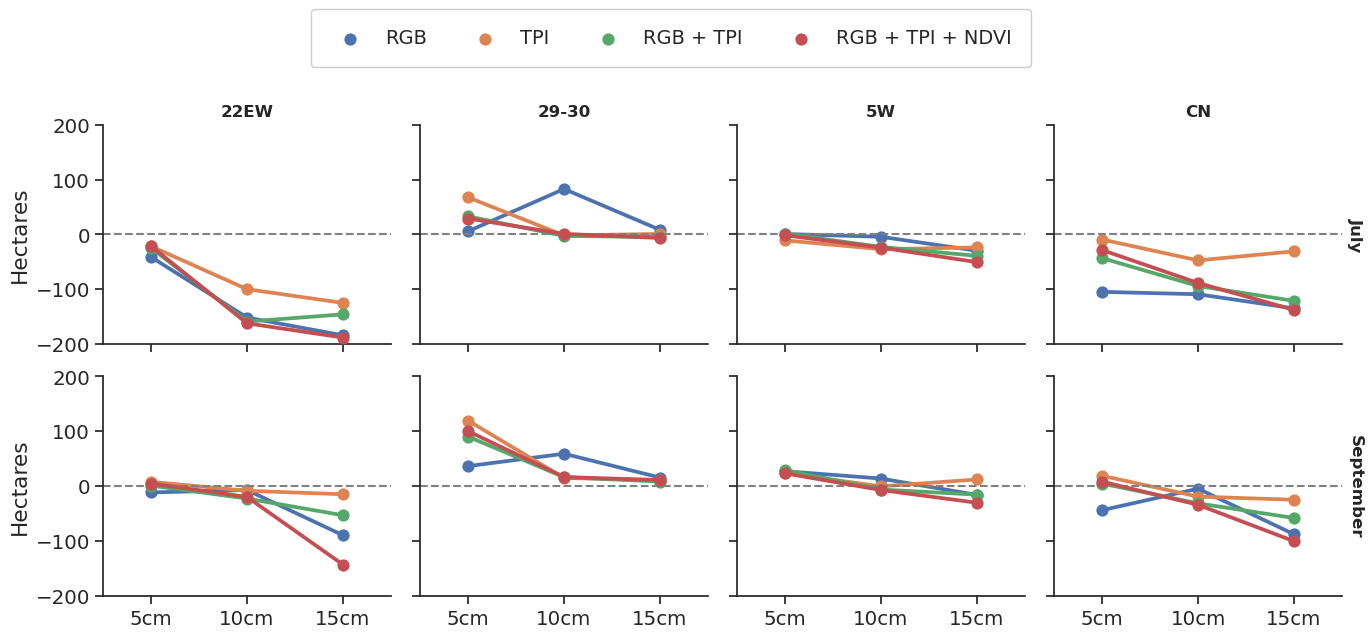

In [97]:
g1 = sns.catplot(data=df_col_val_diff_long,
                 kind='point',
                 hue='inputs', col='Pasture', row='Season', height=3, aspect=1.25,
                    x='resolution', y='diff', 
                    order=['5cm', '10cm', '15cm'], ci=None, join=True, legend=False, margin_titles=True)
g1.set_titles(col_template="{col_name}", row_template="{row_name}", weight='bold', size=12)  # use this argument literally
g1.set_axis_labels(y_var='Hectares', x_var='')
g1.add_legend(bbox_to_anchor=(0.5, 1), loc='lower right', borderpad=1, frameon=True,
    framealpha=1.0, fontsize=14, ncol=4)
for ax in g1.axes.flatten():
    ax.set_ylim((-200, 200))
    ax.axhline(y=0.0, linestyle='dashed', color='grey')
plt.savefig('./results_figs/hectares_diff_colony_pasture_season.png', bbox_inches='tight', dpi=300)
plt.show()

In [98]:
df_col_val_diff_long

,Pasture,resolution,inputs,Season,diff
0,22EW,10cm,RGB,September,-7.0925
1,29-30,10cm,RGB,September,59.0675
2,5W,10cm,RGB,September,13.8050
3,CN,10cm,RGB,September,-4.6600
4,22EW,15cm,RGB,September,-89.5075
...,...,...,...,...,...
91,CN,15cm,TPI,July,-30.9625
92,22EW,5cm,TPI,July,-21.8325
93,29-30,5cm,TPI,July,67.4600
94,5W,5cm,TPI,July,-10.9975


### Subset figures for a single input/resolution combo

In [118]:
inputs_sub = 'RGB + TPI'
suffix_sub = 'rgb_tpi'
res_sub = '5cm'

In [104]:
col_type_dict = {
    1: 'Core',
    2: 'Core',
    3: 'Core',
    4: '+Edge',
    5: '+Transition',
    6: '+Transition'
}
df_col_val['type'] = df_col_val['conn_thresh'].apply(lambda x: col_type_dict[x]) 
df_tmp = df_col_val[(df_col_val['conn_thresh'].isin([3, 4, 6])) &
                    (df_col_val['yrs_thresh'] == 0) &
                    (df_col_val['inputs'] == inputs_sub) &
                    (df_col_val['resolution'] == res_sub) &
                    (df_col_val['Pasture'] != 'Total')]
df_out = pd.melt(df_tmp,
        id_vars=['Pasture', 'type'], value_vars=['ha_pred', 'ha_pred_july'], var_name='Season', value_name='ha')
df_out['Season'] = df_out['Season'].apply(lambda x: 'Sep. 2021' if x == 'ha_pred' else 'July 2021')
df_out = pd.concat([df_out, pd.DataFrame({'ha': pd.concat([df_tmp.groupby('Pasture')['ha_obs'].first(),
                                 df_tmp.groupby('Pasture')['ha_obs_july'].first()]),
              'type': ['Ground' for x in range(8)],
              'Season': ['Sep. 2021' for x in range(4)] + ['July 2021' for x in range(4)]}).reset_index()]).reset_index(drop=True)

In [105]:
df_col_val[(df_col_val['conn_thresh'] == 1) &
           (df_col_val['yrs_thresh'] == 1) &
           (df_col_val['inputs'] == inputs_sub) &
           (df_col_val['resolution'] == res_sub)]

,Pasture,yrs_thresh,conn_thresh,ha_obs,ha_pred,jscore,ha_obs_july,ha_pred_july,jscore_july,inputs,resolution,ha_diff,ha_diff_july,type
6,22EW,1,1,179.8375,160.3975,0.868166,191.2325,144.2700,0.751263,RGB + TPI,5cm,-19.44,-46.9625,Core
30,29-30,1,1,66.8925,69.1725,0.489858,68.9825,29.6175,0.245264,RGB + TPI,5cm,2.28,-39.3650,Core
54,5W,1,1,51.1700,69.5400,0.655035,61.1450,53.9650,0.757807,RGB + TPI,5cm,18.37,-7.1800,Core
78,CN,1,1,127.6275,104.9275,0.753941,144.2675,89.6100,0.613560,RGB + TPI,5cm,-22.70,-54.6575,Core
102,Total,1,1,425.5275,404.0375,0.731959,465.6275,317.4625,0.627411,RGB + TPI,5cm,-21.49,-148.1650,Core


In [106]:
df_col_april['Season'] = 'April 2021'
df_col_april['type'] = 'Ground'
df_col_april = df_col_april.rename(columns={'ha_obs_2020': 'ha'})

In [107]:
df_col_2020['Season'] = 'Sep. 2020'
df_col_2020['type'] = 'Ground'
df_col_2020 = df_col_2020.rename(columns={'ha_obs_2020': 'ha'})

In [108]:
df_out = pd.concat([df_out, df_col_april, df_col_2020])

In [109]:
df_out_total = df_out.groupby(['type', 'Season']).sum().reset_index()
df_out_total['Pasture'] = 'Total'
df_out = pd.concat([df_out, df_out_total])

In [110]:
df_out['Pasture'] = pd.Categorical(df_out['Pasture'], categories=['22EW', 'CN', '5W', '29-30', 'Total'], ordered=True)
df_out['type'] = pd.Categorical(df_out['type'], categories=['Ground', 'Core', '+Edge', '+Transition'], ordered=True)
df_out['Season'] = pd.Categorical(df_out['Season'], categories=['Sep. 2020', 'April 2021', 'July 2021', 'Sep. 2021'], ordered=True)

In [111]:
#df_out[df_out['Season'].isin(['July 2021', 'Sep. 2021'])].sort_values(['Pasture', 'type', 'Season'])

In [112]:
pd.pivot(df_out.sort_values(['Pasture', 'type', 'Season']).set_index(['Pasture', 'type']),
         index=None, columns='Season', values='ha')

Season               Sep. 2020  April 2021  July 2021  Sep. 2021
Pasture type                                                    
22EW    Ground        173.3625    169.0125   189.5550   173.8425
        Core               NaN         NaN   164.5550   174.8100
        +Edge              NaN         NaN   177.4550   186.3050
        +Transition        NaN         NaN   184.2500   196.9425
CN      Ground         91.7725    141.9475   140.7600   117.3525
        Core               NaN         NaN    97.3700   121.9775
        +Edge              NaN         NaN   119.0800   135.6500
        +Transition        NaN         NaN   133.5425   147.3075
5W      Ground         32.6875     36.9975    57.7125    45.9200
        Core               NaN         NaN    58.7750    75.0800
        +Edge              NaN         NaN    68.2400    82.7525
        +Transition        NaN         NaN    75.0000    89.3850
29-30   Ground         66.6175     23.5325     8.0550     0.6975
        Core               NaN         NaN    40.8500    90.9525
        +Edge              NaN         NaN    64.1875   118.5200
        +Transition        NaN         NaN    90.5700   139.8900
Total   Ground        364.4400    371.4900   396.0825   337.8125
        Core               NaN         NaN   361.5500   462.8200
        +Edge              NaN         NaN   428.9625   523.2275
        +Transition        NaN         NaN   483.3625   573.5250

In [113]:
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

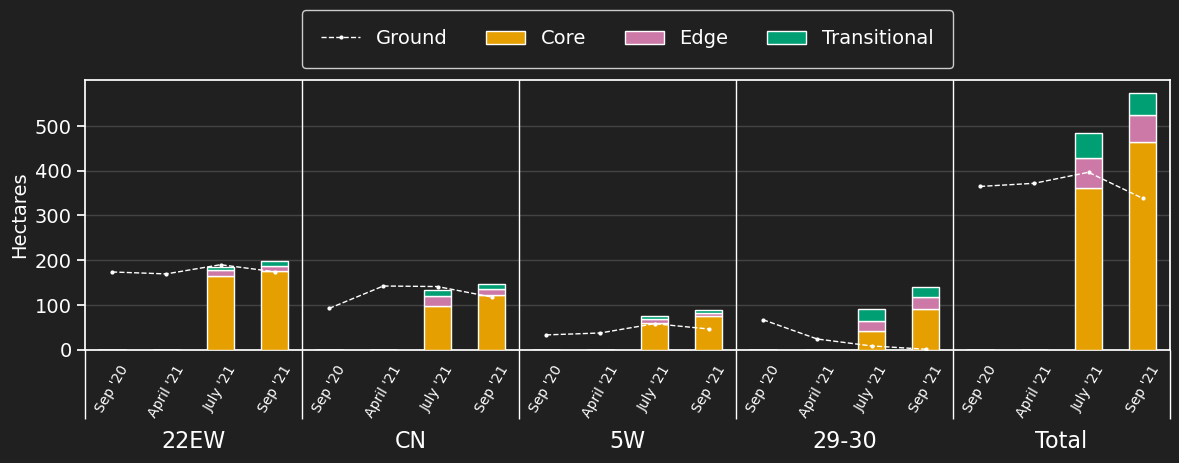

In [114]:
cmap_conn_simp = ListedColormap(['#000000', '#E69F00', '#CC79A7', '#009E73'])
df_out_bar = pd.pivot(df_out.sort_values(['Season', 'type']), index=['Pasture', 'Season'], columns=['type'], values='ha')
df_out_bar['+Edge'] = df_out_bar['+Edge'] - df_out_bar['Core']
df_out_bar['+Transition'] = df_out_bar['+Transition'] - (df_out_bar['Core'] + df_out_bar['+Edge'])
df_out_bar['Ground'] = 0

matplotlib.rc('axes',edgecolor='white')
fig = plt.figure(figsize=(14, 3.5))
ax = plt.subplot()
df_out_bar.plot.bar(
    figsize=(14, 3.5), cmap=cmap_conn_simp, stacked=True, ax=ax, zorder=5)
for past in df_out['Pasture'].unique().sort_values():
    df_out_tmp = pd.pivot(df_out[(df_out['type'] == 'Ground')].sort_values(['Season', 'type']),
             index=['Pasture', 'Season'], 
             columns=['type'], 
             values='ha')
    df_out_tmp.loc[[x for x in df_out['Pasture'].unique().sort_values() if x != past], 'Ground'] = np.nan
    df_out_tmp.plot(ax=ax, marker="o", lw=1, markersize=2, color='white', 
                    linestyle='dashed', zorder=10)


ax.set_facecolor('#202020')
ax.set_ylabel('Hectares')
fig.set_facecolor('#202020')

ax.legend(
    handles=list(map(lambda i: ax.get_legend_handles_labels()[0][i], [0, 6, 7, 8])),
    labels=['Ground', 'Core', 'Edge', 'Transitional'], 
           bbox_to_anchor=(0.5, 1.01), loc='lower center', borderpad=1,
           facecolor='#202020', labelcolor='white', framealpha=1.0, fontsize=14, ncol=4)
ax.set_xlabel('')
ax.set_ylabel('Hectares', fontsize=14, color='white')
cur_xticks = df_out['Pasture'].unique().sort_values()
xticks = []
for i in [0, 4, 8, 12, 16]:
    for x in list(np.arange(0, 4, 1)):
        xticks.append(i + x)
xlbls = []
for i in range(5):
    [xlbls.append(x) for x in ["Sep '20", "April '21", "July '21", "Sep '21"]]

for idx, x in enumerate([1.5, 5.5, 9.5, 13.5, 17.5]):
    ax.text(x, -220, cur_xticks[idx], fontsize=16, color='white', horizontalalignment='center')

ax.set_xticks(xticks, major=True)
ax.set_xticks([-0.5, 3.5, 7.5, 11.5, 15.5, 19.5], minor=True, color='white')
ax.set_xticklabels(xlbls, rotation=60, fontsize=10, color='white')
for v in [3.5, 7.5, 11.5, 15.5]:
    ax.axvline(x=v, color='white', lw=1)

#ax.grid( 'off', axis='x' )
#ax.grid( 'off', axis='x', which='minor' )

# vertical alignment of xtick labels
#va = [ 0, -.05, 0, -.05, -.05, -.05 ]
#for t, y in zip( ax.get_xticklabels( ), va ):
#    t.set_y( y )

ax.tick_params(axis='x', which='minor', direction='out', length=50, color='white')
ax.tick_params(axis='x', which='major', bottom=False, top=False)
ax.set_yticks(np.arange(0, 600, 100))
ax.tick_params(axis='y', labelsize=14, color='white', labelcolor='white')
ax.grid(axis = 'y', linewidth=1, color='lightgrey', alpha=0.2, zorder=0)
#ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, color='white')
plt.savefig('results_figs/pred_vs_obs_ha_' + inputs_sub + '_' + res_sub + '.png', dpi=300, bbox_inches='tight')
plt.show()

### Burrow density plots

In [119]:
df_out = pd.read_csv('cnn_test_results_downscaled/burrow_density_and_colony_class_' + suffix_sub + '_' + res_sub + '.csv')

In [120]:
df_out['box_x'] = df_out.apply(lambda x: -1 if x['yrs_old'] == 1 else x['yrs_active'], axis=1)
df_out['box_x_july'] = df_out.apply(lambda x: -1 if x['yrs_old_july'] == 1 else x['yrs_active_july'], axis=1)
df_out_boxplot = df_out.loc[df_out['box_x'].notnull()].copy()

In [121]:
df_out_boxplot['box_x'] = df_out_boxplot['box_x'].astype('int')
df_out_boxplot.loc[df_out_boxplot['box_x'] == 0, 'box_x'] = 'N/A'

df_out_boxplot['box_x_july'] = df_out_boxplot['box_x_july'].astype('int')
df_out_boxplot.loc[df_out_boxplot['box_x_july'] == 0, 'box_x_july'] = 'N/A'

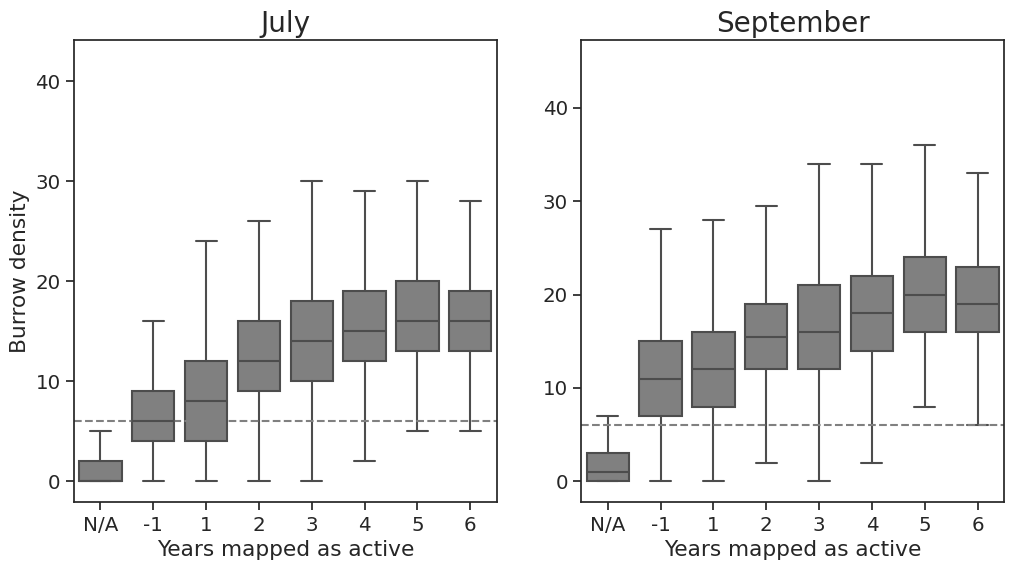

In [130]:
sns.set_style("ticks", {'legend.frameon':True})
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.boxplot(x='box_x_july', y='pts_sum_july', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Burrow density')
axs[0].set_xlabel('Years mapped as active')
axs[0].axhline(y=6, linestyle='dashed', color='grey')
axs[0].set_title('July', fontsize=20)

sns.boxplot(x='box_x', y='pts_sum', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[1])
axs[1].set_ylabel('')
axs[1].set_xlabel('Years mapped as active')
axs[1].axhline(y=6, linestyle='dashed', color='grey')
axs[1].set_title('September', fontsize=20)

#axs[0].axhline(y=4, linestyle='dashed', color='red')
#axs[1].axhline(y=4, linestyle='dashed', color='red')
plt.savefig('./results_figs/burrow_density_vs_yrs_active_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

In [131]:
col_type_dict2 = {
    0: 'N/A',
    1: 'Core',
    2: 'Core',
    3: 'Core',
    4: 'Edge',
    5: 'Transitional',
    6: 'Transitional',
    7: 'N/A'
}

In [133]:
df_out_30m = pd.read_csv('cnn_test_results_downscaled/satellite_metrics_and_burrow_density_' + suffix_sub + '_' + res_sub + '.csv')

In [134]:
df_out_30m['col_type'] = df_out_30m['conn_class'].apply(lambda x: col_type_dict2[x] if not np.isnan(x) else x) 
df_out_30m['col_type'] = pd.Categorical(df_out_30m['col_type'], categories=['Core', 'Edge', 'Transitional', 'N/A'], ordered=True)

In [135]:
df_out_sub_long = pd.melt(df_out_30m.reset_index(), id_vars=['index', 'Pasture', 'col_type', 'pts_sum'], var_name='metric',
                               value_vars=['bm_z', 'bare_z', 'bm_z_july', 'bare_z_july', 'bm_slope_z', 'bare_slope_z'],
                               value_name='z-score')#.dropna(subset='z-score')

In [136]:
df_out_sub_long['Season'] = df_out_sub_long['metric'].apply(lambda x: 'July' if 'july' in x else 'Change (July-Sept.)' if 'slope' in x else 'September')
df_out_sub_long['Season'] = pd.Categorical(df_out_sub_long['Season'], ['July', 'September', 'Change (July-Sept.)'], ordered=True)
df_out_sub_long['metric'] = df_out_sub_long['metric'].apply(lambda x: re.sub('_july', '', re.sub('_slope', '', x)))

In [137]:
metric_dict = {
    'bm_z': 'Biomass',
    'bare_z': 'Bare ground'
}
df_out_sub_long['metric'] = df_out_sub_long['metric'].apply(lambda x: metric_dict[x])

In [138]:
from scipy.stats import pearsonr
df_out_sub_long.dropna(subset=['z-score']).groupby(['Season', 'metric']).apply(lambda x: pearsonr(x['pts_sum'], x['z-score']))

Season               metric     
July                 Bare ground      (0.2747377620062796, 1.270275443511377e-303)
                     Biomass                            (-0.4318535815343994, 0.0)
September            Bare ground                        (0.40681311459645186, 0.0)
                     Biomass                             (-0.460391068354756, 0.0)
Change (July-Sept.)  Bare ground                         (0.4603239760024566, 0.0)
                     Biomass        (-0.2667756523796402, 3.3598353971434156e-283)
dtype: object

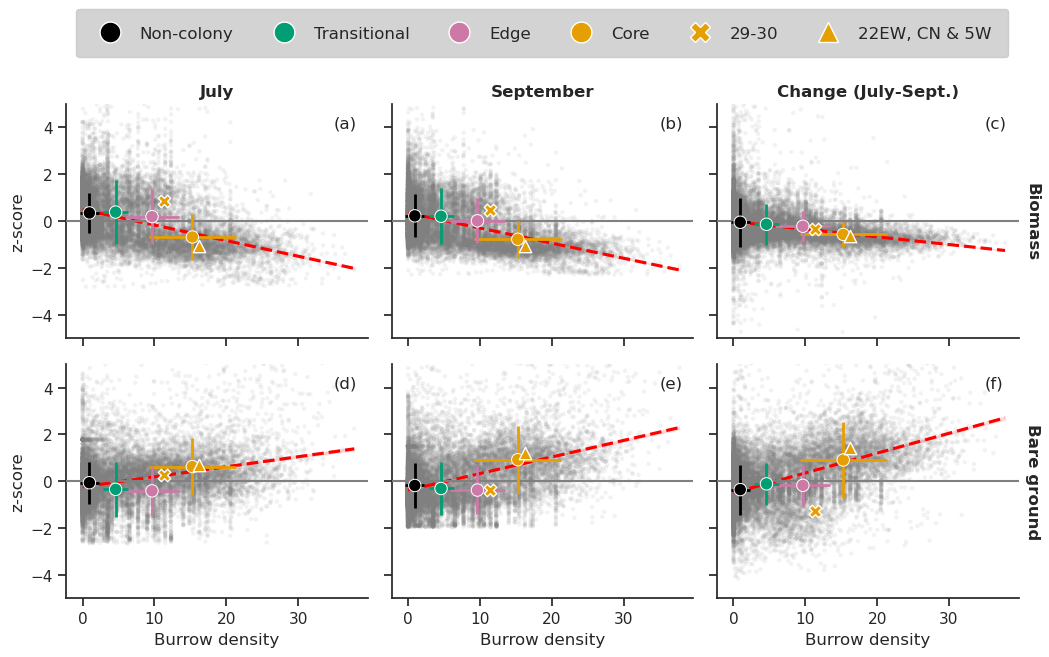

In [142]:
sns.set(font_scale=1)
sns.set_style("ticks", {'legend.frameon':True})
pointsize=10
color_list = ['#E69F00', '#CC79A7', '#009E73', '#000000']
g = sns.FacetGrid(data=df_out_sub_long, row='metric', col='Season', height=3, aspect=1.3, margin_titles=True)
g.map_dataframe(sns.scatterplot, x='pts_sum', y='z-score', color='grey', 
                s=pointsize, ec='none', alpha=0.1, zorder=1)
g.map_dataframe(sns.regplot, x='pts_sum', y='z-score', scatter=False, 
            line_kws=dict(color='red', linestyle='dashed'))
g.set_axis_labels(x_var='Burrow density')
g.set_titles(col_template="{col_name}", row_template="{row_name}", weight='bold', size=12)  # use this argument literally
g.add_legend(
    {'Non-colony':  Line2D([0], [0], marker='o', color='w', linewidth=0,
                          markerfacecolor='#000000', markersize=15),
     'Transitional':  Line2D([0], [0], marker='o', color='w', linewidth=0,
                          markerfacecolor='#009E73', markersize=15),
     'Edge':  Line2D([0], [0], marker='o', color='w', linewidth=0,
                          markerfacecolor='#CC79A7', markersize=15),
     'Core':  Line2D([0], [0], marker='o', color='w', linewidth=0,
                          markerfacecolor='#E69F00', markersize=15),
     '29-30': Line2D([0], [0], marker='X', color='w', linewidth=0,
                          markerfacecolor='#E69F00', markersize=15),
     '22EW, CN & 5W': Line2D([0], [0], marker='^', color='w', linewidth=0,
                          markerfacecolor='#E69F00', markersize=15)},
    bbox_to_anchor=(0.29, 1), loc='lower center', borderpad=1, frameon=True,
    facecolor='lightgrey', framealpha=1.0, fontsize=12, ncol=6)
subplot_letters = ['(a)', '(d)', '(b)', '(e)', '(c)', '(f)']
idx = 0
for c, season in enumerate(g.col_names):
    for r, metric in enumerate(g.row_names):
        ax=g.axes[r, c]
        ax.axhline(y=0, linestyle='solid', color='grey', zorder=8)
        df_tmp = df_out_sub_long[(df_out_sub_long['Season'] == season) & (df_out_sub_long['metric'] == metric)]
        df_tmp_mean = df_tmp.groupby('col_type').mean()
        df_tmp_std = df_tmp.groupby('col_type').std()# / np.sqrt(df_tmp.groupby('col_type').count())
        df_tmp_2930_mean = df_tmp[(df_tmp['Pasture'] == '29-30') & (df_tmp['col_type'] == 'Core')][['pts_sum', 'z-score']].mean()
        df_tmp_active_mean = df_tmp[(df_tmp['Pasture'] != '29-30') & (df_tmp['col_type'] == 'Core')][['pts_sum', 'z-score']].mean()
        sns.scatterplot(data=df_tmp_mean, x='pts_sum', y='z-score', hue='col_type', palette=color_list,  
                        s=pointsize*8, ec='white', ax=ax, legend=False, zorder=10)
        ax.errorbar(x=df_tmp_mean['pts_sum'], y=df_tmp_mean['z-score'], fmt='none',
                     xerr=df_tmp_std['pts_sum'], yerr=df_tmp_std['z-score'],
                     ecolor=color_list, elinewidth=2, zorder=9)
        ax.scatter(x=df_tmp_2930_mean['pts_sum'], y=df_tmp_2930_mean['z-score'], s=pointsize*8, c='#E69F00', marker='X', ec='white', zorder=11)
        ax.scatter(x=df_tmp_active_mean['pts_sum'], y=df_tmp_active_mean['z-score'], s=pointsize*8, c='#E69F00', marker='^', ec='white', zorder=11)
        ax.set_ylim((-5, 5))
        ax.text(x=35, y=4, s=subplot_letters[idx], fontsize=12)
        idx += 1
plt.savefig('./results_figs/burrow_density_vs_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [473]:
from matplotlib.lines import Line2D
Line2D([0], [0], marker='X', color='w', label='29-30',
                          markerfacecolor='#E69F00', markersize=pointsize*8)


In [428]:
df_tmp_mean

,index,pts_sum,z-score
col_type,,,
Core,6923.835587,15.273696,0.626831
Edge,5891.203588,9.657020,-0.408876
Transitional,6235.350546,4.591965,-0.345134
N/A,11381.046343,0.940561,-0.062070


In [433]:
df_tmp[(df_tmp['Pasture'] != '29-30') & (df_tmp['col_type'] == 'Core')].mean()['z-score']

/tmp/ipykernel_286/2758303836.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_tmp[(df_tmp['Pasture'] != '29-30') & (df_tmp['col_type'] == 'Core')].mean()['z-score']


0.7145783566912642

In [423]:
df_tmp.col_type.unique()

['N/A', NaN, 'Transitional', 'Core', 'Edge']
Categories (4, object): ['Core' < 'Edge' < 'Transitional' < 'N/A']

In [318]:
df_tmp_mean.index

CategoricalIndex(['Core', 'Edge', 'Transitional', 'N/A'], categories=['Core', 'Edge', 'Transitional', 'N/A'], ordered=True, dtype='category', name='col_type')

In [303]:
df_tmp.groupby('col_type').std() / np.sqrt(df_tmp.groupby('col_type').count())

,index,metric,pts_sum,z-score
col_type,,,,
Core,57.597266,NaN,0.083850,0.022711
Edge,81.315187,NaN,0.078191,0.018121
Transitional,133.159532,NaN,0.054786,0.028148
N/A,53.792602,NaN,0.014404,0.011736


In [320]:
df_tmp_std.sort_index()

,index,pts_sum,z-score
col_type,,,
Core,4140.197892,6.027293,1.632522
Edge,3976.138047,3.823393,0.886083
Transitional,4204.553087,1.729893,0.888771
N/A,4918.126751,1.316931,1.073008


['bm_z', 'bare_z', 'bm_slope_z', 'bare_slope_z']

In [239]:
from scipy.stats import gaussian_kde
xy_bm = np.vstack([df_out_sub['pts_sum'], df_out_sub['bm_z']])
z_bm = gaussian_kde(xy_bm)(xy_bm)

xy_bare = np.vstack([df_out_sub['pts_sum'], df_out_sub['bare']])
z_bare = gaussian_kde(xy_bare)(xy_bare)

xy_bm_slope = np.vstack([df_out_sub['pts_sum'], df_out_sub['bm_slope_z']])
z_bm_slope = gaussian_kde(xy_bm_slope)(xy_bm_slope)

xy_bare_slope = np.vstack([df_out_sub['pts_sum'], df_out_sub['bare_slope_z']])
z_bare_slope = gaussian_kde(xy_bare_slope)(xy_bare_slope)

# CONSIDER POINTS OF EACH COLONY CLASS WITH ERROR BARS IN THE SCATTER PLOT

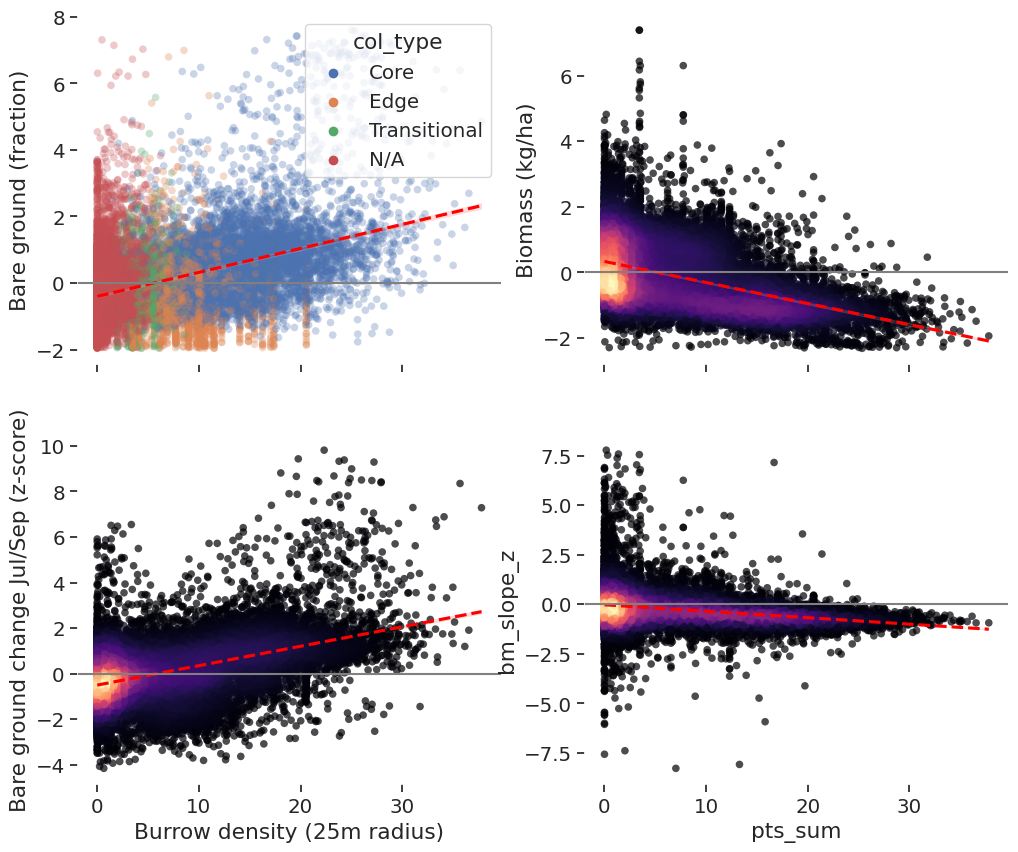

In [243]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 10))
pointsize = 25
sns.scatterplot(x='pts_sum', y='bare_z', data=df_out_sub, hue='col_type', s=pointsize,
                c=z_bare, ec='none', alpha=0.2, ax=axs[0, 0])
sns.pointplot()
sns.regplot(x='pts_sum', y='bare_z', data=df_out_sub, scatter=False, 
            line_kws=dict(color='red', linestyle='dashed'), ax=axs[0, 0])
#sns.regplot(x='pts_sum', y='bare_z', data=df_out_sub[df_out_sub['col_type'] == 'Core'], scatter=False, 
#            line_kws=dict(color='orange', linestyle='dashed'), ax=axs[0, 0])
#sns.regplot(x='pts_sum', y='bare_z', data=df_out_sub[df_out_sub['col_type'] == 'Edge'], scatter=False, 
#            line_kws=dict(color='yellow', linestyle='dashed'), ax=axs[0, 0])
#sns.regplot(x='pts_sum', y='bare_z', data=df_out_sub[df_out_sub['col_type'] == 'Transitional'], scatter=False, 
#            line_kws=dict(color='green', linestyle='dashed'), ax=axs[0, 0])

sns.scatterplot(x='pts_sum', y='bm_z', data=df_out_sub, s=pointsize, 
                c=z_bm, cmap='magma', ec='none', alpha=0.7, ax=axs[0, 1])
sns.regplot(x='pts_sum', y='bm_z', data=df_out_sub, scatter=False, 
            line_kws=dict(color='red', linestyle='dashed'), ax=axs[0, 1])

sns.scatterplot(x='pts_sum', y='bare_slope_z', data=df_out_sub,  s=pointsize,
                c=z_bare_slope, cmap='magma', ec='none', alpha=0.7, ax=axs[1, 0], zorder=10)
sns.regplot(x='pts_sum', y='bare_slope_z', data=df_out_sub, scatter=False,
            line_kws=dict(color='red', linestyle='dashed', zorder=11), ax=axs[1, 0])

sns.scatterplot(x='pts_sum', y='bm_slope_z', data=df_out_sub,  s=pointsize,
                c=z_bm_slope, cmap='magma', ec='none', alpha=0.7, ax=axs[1, 1], zorder=10)
sns.regplot(x='pts_sum', y='bm_slope_z', data=df_out_sub, scatter=False,
            line_kws=dict(color='red', linestyle='dashed', zorder=11), ax=axs[1, 1])

axs[0, 0].set_ylabel('Bare ground (fraction)')
axs[0, 1].set_ylabel('Biomass (kg/ha)')
for ax in axs.flatten():
    ax.axhline(y=0, linestyle='solid', color='grey', zorder=15)
axs[1, 0].set_ylabel('Bare ground change Jul/Sep (z-score)')
axs[1, 0].set_xlabel('Burrow density (25m radius)')
#plt.savefig('./results_figs/burrow_density_and_satellite_metrics' + suffix + '_20ha.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

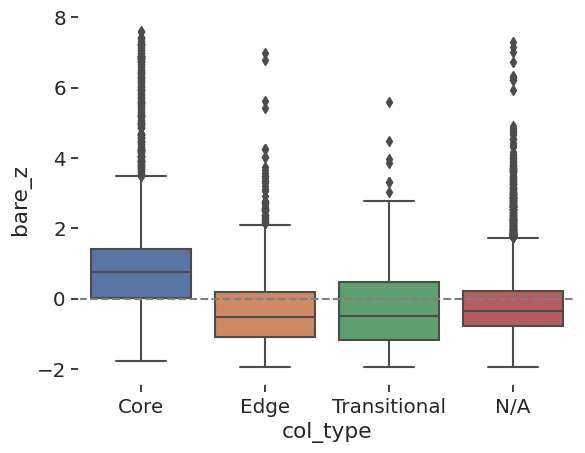

In [227]:
sns.boxplot(x='col_type', y='bare_z', data=df_out_30m)
plt.axhline(y=0, linestyle='dashed', color='grey')
plt.show()

In [221]:
df_out_30m[df_out_30m['conn_class'].isnull()]

,Pasture,yrs_active,yrs_old,conn_class,yrs_active_july,yrs_old_july,conn_class_july,pts_sum,pts_sum_july,bm_slope_z,bare_slope_z,bm,bare,bm_z,bare_z,bm_july,bare_july,bm_z_july,bare_z_july,col_type
168,5W,NaN,NaN,NaN,NaN,NaN,NaN,1.226038,3.070325,-0.634464,1.668161,227.56508,0.407945,-1.695691,3.669701,281.57230,NaN,-1.933746,NaN,
197,5W,NaN,NaN,NaN,NaN,NaN,NaN,4.507556,5.215694,-0.760679,2.039426,333.34000,0.248363,-1.310287,1.467302,394.27164,NaN,-1.393226,NaN,
226,5W,NaN,NaN,NaN,NaN,NaN,NaN,13.013892,8.224918,-0.864272,1.125753,419.69430,0.169006,-0.995645,0.372080,511.33295,NaN,-0.831785,NaN,
255,5W,NaN,NaN,NaN,NaN,NaN,NaN,18.053192,11.668826,-0.852561,1.941978,331.14500,0.267446,-1.318285,1.730658,417.20996,NaN,-1.283211,NaN,
268,5W,NaN,NaN,NaN,NaN,NaN,NaN,2.975971,0.471517,0.014005,-0.225800,729.08844,0.116512,0.131671,-0.352385,722.08860,NaN,0.179025,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15839,CN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.019757,-0.476533,-0.621819,582.25690,0.107318,-0.403328,-0.479277,600.26060,NaN,-0.405277,NaN,
15894,CN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.136959,-0.236655,-1.330005,660.96600,0.098209,-0.116542,-0.604990,675.15840,NaN,-0.046058,NaN,
15949,CN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.019757,-0.455756,-1.397946,688.90980,0.092076,-0.014725,-0.689635,709.21515,NaN,0.117283,NaN,
16004,CN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.104596,-1.777617,789.52850,0.088393,0.351891,-0.740465,759.12100,NaN,0.356637,NaN,


### Old code

In [122]:
df_col_val_long = pd.melt(df_col_val[(df_col_val['yrs_thresh'] == 0) &
                                     (df_col_val['inputs'] == inputs_sub) &
                                     (df_col_val['resolution'] == res_sub)],
                      id_vars=['Pasture', 'conn_thresh'], 
                      value_vars=['ha_pred'],
                      value_name='hectares')
df_pred_wide = pd.pivot(df_col_val[(df_col_val['yrs_thresh'] == 0) &
                                   (df_col_val['inputs'] == inputs_sub) &
                                   (df_col_val['resolution'] == res_sub)],
                       index='Pasture',
                       columns='conn_thresh',
                       values=['ha_pred', 'ha_pred_july'])
df_pred_wide.index = pd.Categorical(values=df_pred_wide.index, categories=['22EW', 'CN', '5W', '29-30'], ordered=True)

In [123]:
past_ordered = df_pred_wide.index.categories.values

In [124]:
for i in ['ha_pred', 'ha_pred_july']:
    for c in range(2, 7):
        df_pred_wide.loc[:, (i, c)] = df_pred_wide.loc[:, (i, c)] - df_pred_wide[[(i, x) for x in range(1, c)]].sum(axis=1)

In [125]:
df_pred_wide = df_pred_wide.unstack().unstack(level=1)#.reset_index(level=1, drop=True).rename_axis('names').reset_index()

In [126]:
df_pred_wide = df_pred_wide.reorder_levels([1, 0])
df_pred_wide.index = df_pred_wide.index.set_names('month', level=1)

In [131]:
df_pred_wide.sort_index(level=1, ascending=False).sort_index(level=0, sort_remaining=False)

conn_thresh                1        2        3        4        5       6
      month                                                             
22EW  ha_pred_july  144.2700   3.4175  16.8675  12.9000   6.7275  0.0675
      ha_pred       160.3975   2.4050  12.0075  11.4950   5.5575  5.0800
CN    ha_pred_july   89.6100   3.8350   3.9250  21.7100  12.3225  2.1400
      ha_pred       104.9275   2.8675  14.1825  13.6725   7.6975  3.9600
5W    ha_pred_july   53.9650   2.2950   2.5150   9.4650   6.6675  0.0925
      ha_pred        69.5400   2.3575   3.1825   7.6725   6.0625  0.5700
29-30 ha_pred_july   29.6175   6.9375   4.2950  23.3375  21.9550  4.4275
      ha_pred        69.1725  11.4100  10.3700  27.5675  20.7700  0.6000

In [127]:
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

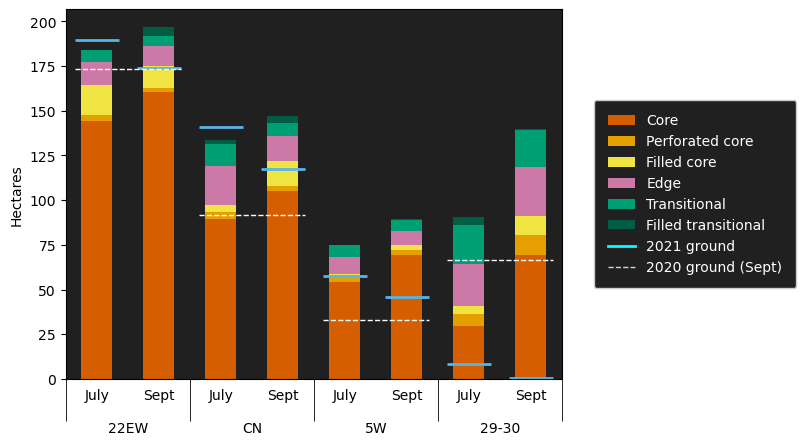

In [129]:
cmap_conn = ListedColormap(['#D55E00', '#E69F00', '#F0E442', '#CC79A7', '#009E73', '#005c42'])
ax = df_pred_wide.sort_index(level=1, ascending=False).sort_index(level=0, sort_remaining=False).plot.bar(
    stacked=True, cmap=cmap_conn)
ax.set_facecolor('#202020')
ax.set_ylabel('Hectares')
#ax.xticks(rotation=0)
for idx, past in enumerate(past_ordered):
    idx = idx*2
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 0)]['ha_obs_july'].values[0],
               xmin=idx-0.35, xmax=idx+0.35,
               linewidth=2,
               color='#56B4E9')
for idx, past in enumerate(past_ordered):
    idx = idx*2+1
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 0)]['ha_obs'].values[0],
               xmin=idx-0.35, xmax=idx+0.35,
               linewidth=2,
               color='#56B4E9')
#for idx, past in enumerate(past_ordered):
#    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
#                        (df_col_val['yrs_thresh'] == 1)]['ha_obs'].values[0],
#               xmin=idx*2-0.35, xmax=idx*2+1+0.35,
#               color='white', linestyle='dashed', linewidth=1)
for idx, past in enumerate(past_ordered):
    plt.hlines(y=df_out[(df_out['Pasture'] == past) &
                        (df_out['Season'] == 'Sep. 2020')]['ha'].values.item(),
               xmin=idx*2-0.35, xmax=idx*2+1+0.35,
               color='white', linestyle='dashed', linewidth=1)
ax.legend(
    handles=ax.get_legend_handles_labels()[0] + [Line2D([0], [0], color='cyan', lw=2, linestyle='solid'),
                                                 Line2D([0], [0], color='lightgrey', lw=1, linestyle='dashed')],
    labels=['Core', 'Perforated core', 'Filled core', 
                   'Edge', 'Transitional', 'Filled transitional', '2021 ground', '2020 ground (Sept)'], 
           bbox_to_anchor=(1.05, 0.5), loc='center left', borderpad=1,
           facecolor='#202020', labelcolor='white', framealpha=1.0)
ax.set_xlabel('')
cur_xticks = past_ordered
xticks = []
for i in [0, 2, 4, 6]:
    for x in list(np.arange(0, 1.5, 0.5)):
        xticks.append(i + x)
xlbls = ['July', '\n\n' + cur_xticks[0], 'Sept',
         'July', '\n\n' + cur_xticks[1], 'Sept',
         'July', '\n\n' + cur_xticks[2], 'Sept',
         'July', '\n\n' + cur_xticks[3], 'Sept']

ax.set_xticks(xticks, major=True)
ax.set_xticks([-0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], minor=True)
ax.set_xticklabels(xlbls, rotation=0)
#ax.set_xlim( -0.5, 7.5 )

#ax.grid( 'off', axis='x' )
#ax.grid( 'off', axis='x', which='minor' )

# vertical alignment of xtick labels
#va = [ 0, -.05, 0, -.05, -.05, -.05 ]
#for t, y in zip( ax.get_xticklabels( ), va ):
#    t.set_y( y )

ax.tick_params( axis='x', which='minor', direction='out', length=30 )
ax.tick_params( axis='x', which='major', bottom=False, top=False)
plt.show()

In [133]:
df_pred_wide['Core'] = df_pred_wide[[1, 2, 3]].sum(axis=1)
df_pred_wide['Edge'] = df_pred_wide[4]
df_pred_wide['Transitional'] = df_pred_wide[[5, 6]].sum(axis=1)

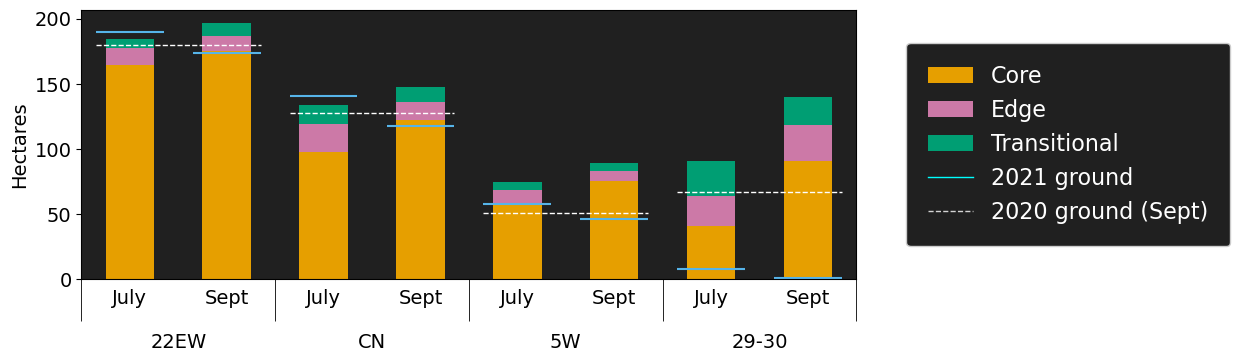

In [135]:
cmap_conn_simp = ListedColormap(['#E69F00', '#CC79A7', '#009E73'])
ax = df_pred_wide[['Core', 'Edge', 'Transitional']].sort_index(level=1, ascending=False).sort_index(level=0, sort_remaining=False).plot.bar(
    stacked=True, cmap=cmap_conn_simp, figsize=(10, 3.5))
ax.set_facecolor('#202020')
ax.set_ylabel('Hectares')
#ax.xticks(rotation=0)
for idx, past in enumerate(past_ordered):
    idx = idx*2
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 0)]['ha_obs_july'].values[0],
               xmin=idx-0.35, xmax=idx+0.35,
               color='#56B4E9')
for idx, past in enumerate(past_ordered):
    idx = idx*2+1
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 0)]['ha_obs'].values[0],
               xmin=idx-0.35, xmax=idx+0.35,
               color='#56B4E9')
for idx, past in enumerate(past_ordered):
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 1)]['ha_obs'].values[0],
               xmin=idx*2-0.35, xmax=idx*2+1+0.35,
               color='white', linestyle='dashed', linewidth=1)
ax.legend(
    handles=ax.get_legend_handles_labels()[0] + [Line2D([0], [0], color='cyan', lw=1, linestyle='solid'),
                                                 Line2D([0], [0], color='lightgrey', lw=1, linestyle='dashed')],
    labels=['Core', 'Edge', 'Transitional', '2021 ground', '2020 ground (Sept)'], 
           bbox_to_anchor=(1.05, 0.5), loc='center left', borderpad=1,
           facecolor='#202020', labelcolor='white', framealpha=1.0, fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Hectares', fontsize=14)
cur_xticks = past_ordered
xticks = []
for i in [0, 2, 4, 6]:
    for x in list(np.arange(0, 1.5, 0.5)):
        xticks.append(i + x)
xlbls = ['July', '\n\n' + cur_xticks[0], 'Sept',
         'July', '\n\n' + cur_xticks[1], 'Sept',
         'July', '\n\n' + cur_xticks[2], 'Sept',
         'July', '\n\n' + cur_xticks[3], 'Sept']

ax.set_xticks(xticks, major=True)
ax.set_xticks([-0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], minor=True)
ax.set_xticklabels(xlbls, rotation=0, fontsize=14)
#ax.set_xlim( -0.5, 7.5 )

#ax.grid( 'off', axis='x' )
#ax.grid( 'off', axis='x', which='minor' )

# vertical alignment of xtick labels
#va = [ 0, -.05, 0, -.05, -.05, -.05 ]
#for t, y in zip( ax.get_xticklabels( ), va ):
#    t.set_y( y )

ax.tick_params(axis='x', which='minor', direction='out', length=30)
ax.tick_params(axis='x', which='major', bottom=False, top=False)
ax.tick_params(axis='y', labelsize=14)
plt.savefig('results_figs/pred_vs_obs_ha_' + inputs_sub + '_' + res_sub + '.png', dpi=300, bbox_inches='tight')
plt.show()